
# Notebook 2: Modelling & Evaluation

In this notebook, I will be conducting modelling to find the best model for classifying my tweets into the 5 categories of emotions: 
- Negativity, Neutral, Optimistic, Anticipation and Contempt.

#### Key sections of the notebook:
1. Understanding Features
    - Mutual Information Score
    - Effect of Punctuations
2. Modelling
    - Train test split
    - Gridsearch
    - Model Tuning
3. Model Evaluation
4. Understanding Model Results
5. Understanding Misclassification

# Data Imports

### Library Imports

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# NLP Imports
import regex as re
from bs4 import BeautifulSoup
import string
# from textblob import TextBlob, Word
from sklearn.feature_extraction import text
import spacy
import en_core_web_sm
sp = en_core_web_sm.load()

# Modelling Imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc,confusion_matrix, roc_auc_score,plot_confusion_matrix, plot_roc_curve, f1_score, SCORERS
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB

# Other Imports
import dill
import multiprocessing
import itertools
from itertools import cycle

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

# Stylistic Choice:
plt.style.use('bmh')
sns.set_palette("RdBu_r")

# Display setting
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)

In [2]:
cores = multiprocessing.cpu_count()
cores

4

### Defining stopwords

In [3]:
# Add stopwords here.
newStopWords = ['sticker','omitted','go','got','get','still','lol','okay','sia','btw','leh',
                'haha','min','chester','one','lot','coz','hmmm','zzz','well','also','ehh',
               'aft','shuck','sup','ohh','ooh','meh','want','okayy','oop','oops','smse','lah'
                ,'lor','hahaha','le','ok','eh','oh','ya','ur','lo','ll','hee','lols','hi','hey',
                'ah','ur','la','bah','ba','rite','just','let','dam','maybe','ooo','sure','ohhh',
                'fine','really','dunno','wo','nee','arh','nvm','day','com','a1','al','did','https',
                'http','tweets','tweet','ed','rt','tweeted','lindseyyx2', ' day', 'day ','sarah',
                'tweet ',' tweet',' tweeter', 'a i','bit ly','bit iy','bit','ly']
stop_list = text.ENGLISH_STOP_WORDS.union(newStopWords)

### Document Imports

In [4]:
df = pd.read_csv('../data/results/modelling/final_df_v3.csv')

In [5]:
df.head()

,sentiment,content,content_final,len_exc,len_qn,len_ellip
0,negativity,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin,0,0,0
1,negativity,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhh waitin,0,0,2
2,negativity,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,0,0,2
3,anticipation,wants to hang out with friends SOON!,hang friend soon,1,0,0
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade ha houston ticket,0,0,0


In [6]:
df.reset_index(inplace=True)

In [7]:
df.drop(columns='index',inplace=True)

In [8]:
df.rename(columns={'sentiment':'msg_emotion'},inplace=True)

In [9]:
df.head()

,msg_emotion,content,content_final,len_exc,len_qn,len_ellip
0,negativity,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin,0,0,0
1,negativity,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhh waitin,0,0,2
2,negativity,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,0,0,2
3,anticipation,wants to hang out with friends SOON!,hang friend soon,1,0,0
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade ha houston ticket,0,0,0


In [10]:
df= df[~df['content_final'].isnull()]

# Understanding Features

## Understanding Top Words that Appear based on Mutual Information Score

The Mutual Information score expresses the extent to which observed frequency of co-occurrence differs from what we would expect (statistically speaking). In statistically pure terms this is a measure of the strength of association between words x and y.
[Source](https://wordbanks.harpercollins.co.uk/other_doc/statistics.html#:~:text=The%20Mutual%20Information%20score%20expresses,between%20words%20x%20and%20y.)

In [11]:
df['msg_emotion'].value_counts()

negativity      14496
neutral          9691
optimistic       9206
anticipation     4682
contempt         3132
Name: msg_emotion, dtype: int64

In [12]:
cvec = CountVectorizer(stop_words = stop_list, ngram_range=(1,3))
cvec_content = cvec.fit_transform(df['content_final'])

In [13]:
# There are a total of 358,195 unique words that appeared in our entire tweet corpus.
cvec_content.shape

(41207, 352851)

In [14]:
# The information below will have been hardcoded as "Raw NBConvert" format as it takes hours to generate. I will not be rerunning this section.

%time mi_content = mutual_info_classif(cvec_content, df['msg_emotion'])                      
mi_content = pd.DataFrame(mi_content, index = cvec.get_feature_names())          

CPU times: user 2h 11min, sys: 24.1 s, total: 2h 11min 24s
Wall time: 2h 11min 42s


In [15]:
mi_content[0].sort_values(ascending=False).head(20)

hate            0.044660
angry           0.038344
happy           0.020082
love            0.015817
mother          0.014291
happy mother    0.013003
sad             0.009353
thanks          0.008245
sorry           0.005053
great           0.004721
love hate       0.004703
miss            0.004675
good            0.004513
awesome         0.004137
suck            0.003795
hurt            0.003531
mom             0.003481
fun             0.003479
bad             0.003425
sick            0.003395
Name: 0, dtype: float64

In [16]:
mi_content

,0
00,0.000110
00 03,0.000025
00 03 wrecked,0.000025
00 88,0.000053
00 88 share,0.000053
...,...
میں ghussay,0.000125
میں ghussay adjective,0.000125
포미닛,0.000063
포미닛 hate,0.000063


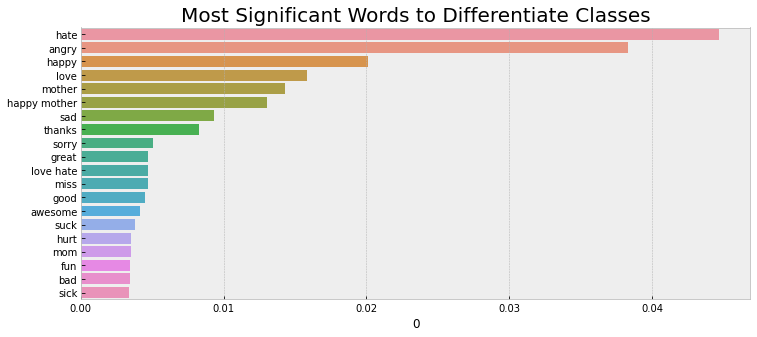

In [17]:
plt.figure(figsize=(12,5))
sns.barplot(data= mi_content.sort_values(by=0,ascending=False).head(20),y=mi_content.sort_values(by=0,ascending=False).head(20).index,x=0)
plt.title('Most Significant Words to Differentiate Classes',size=20);
#plt.xticks(rotation=45, ha='right');

**Predicting Model Performance:**

From the MI chart above, we notice that the words 'hate' and 'angry' were most distinct in identifying the correct class it belongs. From our word cloud previously, we understand that these two words belong in the "Contemp" emotion class. Hence, it is likely that our "Contempt" class would be well classified given the results above.

Moreover, the next few words that followed were words associated with optimism. This is also indicative that our model might perform well for this class.

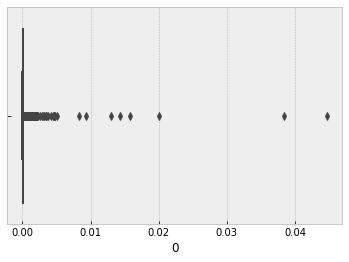

In [18]:
sns.boxplot(mi_content[0].sort_values(ascending=False));

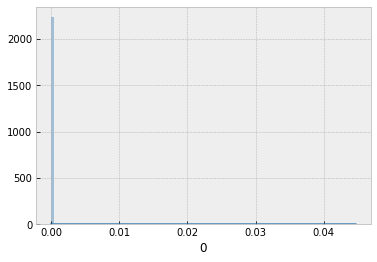

In [19]:
sns.distplot(mi_content[0].sort_values(ascending=False),bins=100);

Our heavily skewed MI representation of boxplot and histogram shows that only a very small proportion of our entire word features (358K words) are useful for our predictive model.

In [20]:
data=mi_content[0].sort_values(ascending=False)

In [21]:
data

hate      0.044660
angry     0.038344
happy     0.020082
love      0.015817
mother    0.014291
            ...   
cooler    0.000002
7th       0.000002
kim       0.000002
martin    0.000002
ng        0.000002
Name: 0, Length: 352851, dtype: float64

In [22]:
mi_content[0].shape

(352851,)

#### Choosing number of features via Quantile Analysis

In [23]:
print(f'25th Quantile: {data.quantile(0.25)}')
print(f'50th Quantile: {data.quantile(0.5)}')
print(f'75th Quantile: {data.quantile(0.75)}')
print(f'90th Quantile: {data.quantile(0.9)}')
print(f'99th Quantile: {data.quantile(0.99)}')

25th Quantile: 2.535389022813577e-05
50th Quantile: 3.5126313178332404e-05
75th Quantile: 5.0708865732556935e-05
90th Quantile: 6.253995418571147e-05
99th Quantile: 0.0001250870702238395


We observe that from 90th to 99th quantile, there is a significant jump in the Mutual information score.
Let's further dive into specifically which quantile gives the jump.

In [24]:
print(f'90th Quantile: {data.quantile(0.9)}')
print(f'95th Quantile: {data.quantile(0.95)}')
print(f'96th Quantile: {data.quantile(0.96)}')
print(f'97th Quantile: {data.quantile(0.97)}')
print(f'98th Quantile: {data.quantile(0.98)}')

90th Quantile: 6.253995418571147e-05
95th Quantile: 6.253995418571147e-05
96th Quantile: 6.402347294927064e-05
97th Quantile: 7.336108567797262e-05
98th Quantile: 0.00010556808901348604


There is minimal increase from 90th to 95th, and from 95th to 96th percentile.
However, we can see that the 97th to 98th quantile gives the highest jump in mutual information score. We will check how many features are in these proportion of the entire word vector.

In [25]:
# Option 1: 90th percentile
print(f'Number of features in 90th Percentile: {(1.0-.9)*mi_content[0].shape[0]}')
# Option 2: 96th percentile
print(f'Number of features in 96th Percentile: {(1.0-.96)*mi_content[0].shape[0]}')
# Option 3: 97th percentile
print(f'Number of features in 97th Percentile: {(1.0-.97)*mi_content[0].shape[0]}')
# Option 4: 98th percentile
print(f'Number of features in 98th Percentile: {(1.0-.98)*mi_content[0].shape[0]}')

Number of features in 90th Percentile: 35285.09999999999
Number of features in 96th Percentile: 14114.040000000012
Number of features in 97th Percentile: 10585.53000000001
Number of features in 98th Percentile: 7057.020000000006


We will be using this information for our gridsearch during modelling phase.
- From 96% percentile (14K features) to 98% percentile (7K features).

## Effect of Punctuations on tweet Emotions

In [26]:
dummy = pd.get_dummies(data=df,columns=['msg_emotion']).drop(columns=['content_final','content'])

In [27]:
dummy.corr()

,len_exc,len_qn,len_ellip,msg_emotion_anticipation,msg_emotion_contempt,msg_emotion_negativity,msg_emotion_neutral,msg_emotion_optimistic
len_exc,1.000000,0.004759,0.006897,0.044422,-0.015652,-0.052398,-0.082527,0.120214
len_qn,0.004759,1.000000,-0.002834,0.030640,-0.006163,-0.004076,0.008401,-0.023305
len_ellip,0.006897,-0.002834,1.000000,-0.000874,-0.011811,0.050674,-0.024326,-0.025147
msg_emotion_anticipation,0.044422,0.030640,-0.000874,1.000000,-0.102686,-0.263754,-0.198536,-0.192032
msg_emotion_contempt,-0.015652,-0.006163,-0.011811,-0.102686,1.000000,-0.211286,-0.159041,-0.153831
msg_emotion_negativity,-0.052398,-0.004076,0.050674,-0.263754,-0.211286,1.000000,-0.408505,-0.395123
msg_emotion_neutral,-0.082527,0.008401,-0.024326,-0.198536,-0.159041,-0.408505,1.000000,-0.297422
msg_emotion_optimistic,0.120214,-0.023305,-0.025147,-0.192032,-0.153831,-0.395123,-0.297422,1.000000


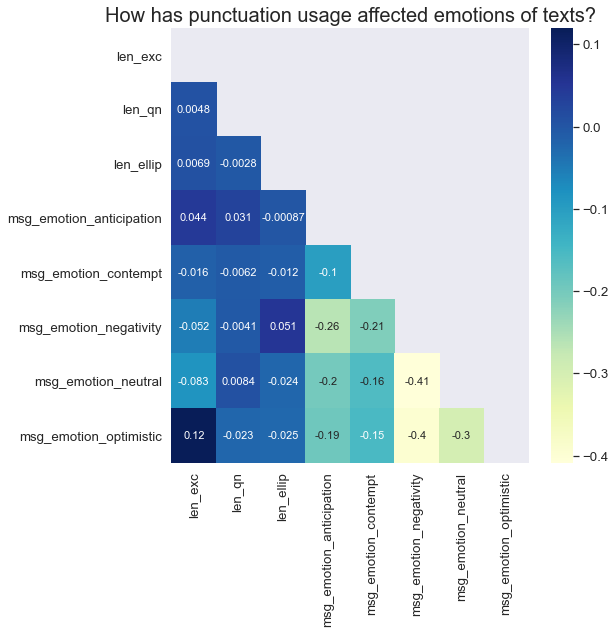

In [28]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1.2)
custom_mask = np.zeros_like(dummy.corr())   
custom_mask[np.triu_indices_from(custom_mask)] = True
sns.heatmap(dummy.corr(),annot=True,cmap="YlGnBu",annot_kws={'fontsize':11},mask=custom_mask)
plt.title('How has punctuation usage affected emotions of texts?',size=20);

**Observations**
- Number of exclaimation marks has the highest positive correlation with optimistic tweets.
- Number of exclaimation marks is also positively correlated to anticipation tweets.
- Sets of ellipsis ('...') has a positive correlation to negativity tweets.

# Modelling

## Train-test-split

In [29]:
dict_emo = {'negativity':1,
            'neutral':2,
            'optimistic':3,
            'anticipation':4,
            'contempt':5    
}
df['msg_emotion'].replace(dict_emo,inplace=True)

In [30]:
df['msg_emotion'].value_counts(normalize=True)

1    0.351785
2    0.235178
3    0.223409
4    0.113621
5    0.076007
Name: msg_emotion, dtype: float64

In [31]:
X = df.loc[:,(df.columns !='msg_emotion')&(df.columns !='content')]
y = df[['msg_emotion']]

In [32]:
def process_features(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, 
                                                        test_size=0.3, stratify=y)
    
    print('Train Data Shape:')
    print("Shape of X_train: " + str(X_train.shape))
    print("Shape of y_train: " + str(y_train.shape))
    print()
    print('Testing Data Shape:')
    print("Shape of X_test: " + str(X_test.shape))
    print("Shape of y_test: " + str(y_test.shape))
    return X_train, X_test, y_train, y_test

In [33]:
X_train, X_test, y_train, y_test = process_features(X,y)

Train Data Shape:
Shape of X_train: (28844, 4)
Shape of y_train: (28844, 1)

Testing Data Shape:
Shape of X_test: (12363, 4)
Shape of y_test: (12363, 1)


##### Check if data has been split equally

In [34]:
y_test.value_counts(normalize=True)

msg_emotion
1              0.351775
2              0.235137
3              0.223409
4              0.113646
5              0.076033
dtype: float64

In [35]:
y_train.value_counts(normalize=True)

msg_emotion
1              0.351789
2              0.235196
3              0.223409
4              0.113611
5              0.075995
dtype: float64

- Baseline accuracy: 35%

##### Defining classweight for modelling purpose

In [36]:
classweight = {5:0.35,
              4:0.24,
              3:0.22,
              2:0.11,
              1:0.08}

## Gridsearch

Chose to conduct gridsearch through 3 models: Multinomial Naives Bayes, Logistic Regression and XGBoost Classifier (Tree based model).

Here are the reasons why I have shortlisted these three algorithms to compute the my best model for text classification.
- **Multinomial Naive Bayes:** A statistically driven approach to predicting classes. Known for text classication and its ability to handle large amount of data. This algorithm would generally result in less overfitting, unlike a tree-based model. Generally high computation speed given the large corpus of data, and performs well despite having large amount of noise (due to irrelevant features/words). Tuning is also not very necessary as compared to other models (ie. tree-based to reduce overfitting).

- **Logistic Regression**: A cousin to Linear Regression, which is a basic statistical modelling that is excellent for feature inference and importance analysis. Logistic Regression, similarly, is great at determining the best features to predicting the different classes of emotions.

- **XGBoost**: This is a modified decision-tree based model, where the first trees would be build weakly and subsequently learn from the previous trees to build better ones. This would hence reduce the problem of overfitting, as compared to traditional tree based models. Generally a strong contendent for machine learning models.

### Will be gridsearching through the following:
- Maximum features for vectorizers kept at 7K - 12K range. This is because the Mutual Information Scores have jumped the greatest during this range of values.
- Will not be using max_df as we do not want to minimalise the effects of high-frequency words in our model as they might be useful in showing the emotions of the text.
- Will be gridsearching through min_df, because in casual tweets (tweets), there are tons of noisy texts that might not be useful for our model.
- Will be gridsearching between having no stop words and current stop word list. 

##### Pipeline Methodology
I will be using a Feature Union to combine both my raw tweet data ('content_final') column together with my 3 punctuation columns ('len_exc','len_qn','len_ellip') for my classifier to conduct modelling.

Through the Feature Union function, data are split into two seperate parts for processing purposes. First pipeline (content_pipeline) would be for vectorizing purposes by converting raw data to sparse matrix. Second pipeline (punc_pipeline) would be to extract numerical features from raw data and perform scaling. 

For reference purposes: [1](https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c) [2](https://towardsdatascience.com/using-functiontransformer-and-pipeline-in-sklearn-to-predict-chardonnay-ratings-9b13fdd6c6fd) [3](https://stackoverflow.com/questions/53841913/perform-feature-selection-using-pipeline-and-gridsearch)

In [37]:
# create separate pipelines for text and numerical data
content_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['content_final'], validate=False)),
    ('vectorizer', None)
])
# numerical pipeline (for number of punctuations)
punc_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['len_exc','len_qn','len_ellip']], validate = False)),
    ('scaler', RobustScaler())
])

# combine pipelines with FeatureUnion
union_pipeline = Pipeline([
    ('union', FeatureUnion([('content',content_pipeline),
                            ('punc_len',punc_pipeline)])),
    ('classifier', None)])

#### Gridsearch 1 (All three models without tuning)

In [38]:
params = {
        'union__content__vectorizer': [CountVectorizer(),
                                     TfidfVectorizer()],
        'union__content__vectorizer__ngram_range': [(1,2),(1,3)],
        'union__content__vectorizer__max_features': [7500, 10000,12000], # Chose this range due to Mutual Infomation Score
        'union__content__vectorizer__min_df': [5,10],                    # Rationale as mentioned above.   
        'union__content__vectorizer__stop_words' :[stop_list,None],      # Understanding if stop_list played a good role.
        'classifier': [MultinomialNB(), LogisticRegression(),XGBClassifier()]
    }

In [39]:
gs_1 = GridSearchCV(union_pipeline, param_grid=params, scoring = 'accuracy',verbose=3,cv=5,n_jobs=2)
gs_1.fit(X_train, y_train)
y_pred_1 = gs_1.predict(X_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 11.4min
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed: 39.8min finished


In [40]:
# call .score on the gs object to use the best parameters found during gridsearch to evaluate train and val 
print('Train accuracy:', gs_1.score(X_train, y_train))
print('Test accuracy:', gs_1.score(X_test, y_test))
print(gs_1.best_params_)

Train accuracy: 0.5706212730550547
Test accuracy: 0.5020626061635526
{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), 'union__content__vectorizer': CountVectorizer(max_features=7500, min_df=10, ngram_range=(1, 3),
                stop_words=frozenset({' day', ' tweet', ' tweeter', 'a', 'a i',
                                      'a1', 'about', 'above', 'across', 'aft',
                            

In [41]:
y_pred_1 = gs_1.predict(X_test)
y_pred_df_1 = pd.DataFrame(y_pred_1,columns=['msg_emotion'])
print(classification_report(y_test, y_pred_df_1['msg_emotion']))
accuracy = accuracy_score(y_test, y_pred_df_1['msg_emotion'])
print(f'Accuracy Score: {round(accuracy,4)}')

              precision    recall  f1-score   support

           1       0.50      0.69      0.58      4349
           2       0.40      0.41      0.40      2907
           3       0.57      0.55      0.56      2762
           4       0.27      0.03      0.05      1405
           5       0.81      0.48      0.60       940

    accuracy                           0.50     12363
   macro avg       0.51      0.43      0.44     12363
weighted avg       0.49      0.50      0.48     12363

Accuracy Score: 0.5021


Our first gridsearch has provided us with XGBoost with CountVectorizer (bi/trigrams, min_df=10 and max_features at 7.5K). This means that XGBoost (without tuning) together with CountVectorizer of those parameters performed better in accuracy score as compared to the other two models.

However, we note that there appears to be overfitting of XGBoost model where train/test accuracy has a 7% difference. We will go on to conduct gridsearch through the three proposed models individually to check if they would give us better results.

### Tuning Model

#### Logistic Regression
- Propose to include 2 additional parameters to be tuned: 
    - C: Inverse of regularization strength. Smaller values indicate higher regularization properties. In the field of casual text messages, we believe that having a greater regularization would be useful for our model as text messages in this field are highly varied.
    - Class Weight: We will be checking whether the 'balanced' mode or default mode would give us a better accuracy score. Balanced mode simply takes into account the properties of imbalanced dataset, where values of y to automatically adjust weights inversely proportional to class frequencies.

In [162]:
# create separate pipelines for text and numerical data
content_pipeline_lr = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['content_final'], validate=False)),
    ('vectorizer', None)
])
# numerical pipeline (for number of punctuations)
punc_pipeline_lr = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['len_exc','len_qn','len_ellip']], validate = False)),
    ('scaler', RobustScaler())
])

# combine pipelines with FeatureUnion
union_pipeline_lr = Pipeline([
    ('union', FeatureUnion([('content',content_pipeline),
                            ('punc_len',punc_pipeline)])),
    ('classifier_lr', LogisticRegression())])

In [170]:
params_lr = {
        'union__content__vectorizer': [CountVectorizer(),
                                     TfidfVectorizer()],
        'union__content__vectorizer__ngram_range': [(1,2),(1,3)],
        'union__content__vectorizer__max_features': [6500],        # Chose this range due to Mutual Infomation Score
        'union__content__vectorizer__min_df': [5,10],                    # Rationale as mentioned above.   
        'union__content__vectorizer__stop_words' :[None],      # Understanding if stop_list played a good role.
        'classifier_lr__C':[0.01,0.1,1],
        'classifier_lr__class_weight':['balanced',None]
    }

In [171]:
gs_lr = GridSearchCV(union_pipeline_lr, param_grid=params_lr, scoring = 'accuracy',verbose=3,cv=5,n_jobs=2)
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   40.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:  6.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('content',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x1a271d4a70>)),
                                                                                        ('vectorizer',
                                                                                         None)])),
                                                                       ('punc_len',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x1a271d4b90>)),
                                                       

In [173]:
# call .score on the gs object to use the best parameters found during gridsearch to evaluate train and val 
print('Train accuracy:', gs_lr.score(X_train, y_train))
print('Test accuracy:', gs_lr.score(X_test, y_test))
print(gs_lr.best_params_)

Train accuracy: 0.5643461378449591
Test accuracy: 0.5106365768826336
{'classifier_lr__C': 0.1, 'classifier_lr__class_weight': None, 'union__content__vectorizer': CountVectorizer(max_features=6500, min_df=10, ngram_range=(1, 2)), 'union__content__vectorizer__max_features': 6500, 'union__content__vectorizer__min_df': 10, 'union__content__vectorizer__ngram_range': (1, 2), 'union__content__vectorizer__stop_words': None}


In [174]:
y_pred_lr = gs_lr.predict(X_test)
y_pred_df_lr = pd.DataFrame(y_pred_lr,columns=['msg_emotion'])
print(classification_report(y_test, y_pred_df_lr['msg_emotion']))
accuracy = accuracy_score(y_test, y_pred_df_lr['msg_emotion'])
print(f'Accuracy Score: {round(accuracy,4)}')

              precision    recall  f1-score   support

           1       0.52      0.71      0.60      4349
           2       0.40      0.41      0.41      2907
           3       0.58      0.56      0.57      2762
           4       0.25      0.03      0.05      1405
           5       0.83      0.47      0.60       940

    accuracy                           0.51     12363
   macro avg       0.51      0.44      0.44     12363
weighted avg       0.50      0.51      0.48     12363

Accuracy Score: 0.5106


It appears that a C value of 0.1 for logistic regression helps in regularizing the model and provide for the best accuracy score. So far, this model gave us the best results with a 1% increase in accuracy.

Note that the combination of parameters for our vectorizer has also changed (Currently, uni/bigram would be more useful as compared to bi/tri gram).

#### Gridsearch: XGBoost

We will be conducting hyperparameter tuning for the two shortlisted parameters:
- Learning rate: Makes the model more robust by shrinking the weights on each step
- Max_depth: Noted that the first unified gridsearch we conducted gave us a train/test score with 7% difference. BY shrinking the max depth of the tree and limiting the growth of it, we will be able to have a more generic, regularized model, preventing overfitting of model.

In [175]:
xgb=XGBClassifier()
# create separate pipelines for text and numerical data
content_pipeline_xgb = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['content_final'], validate=False)),
    ('vectorizer', None)
])
# numerical pipeline (for number of punctuations)
punc_pipeline_xgb = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['len_exc','len_qn','len_ellip']], validate = False)),
    ('scaler', RobustScaler())
])

# combine pipelines with FeatureUnion
union_pipeline_xgb = Pipeline([
    ('union', FeatureUnion([('content',content_pipeline),
                            ('punc_len',punc_pipeline)])),
    ('classifier_xgb', XGBClassifier())])

In [177]:
params_xgb = {
        'union__content__vectorizer': [CountVectorizer(),
                                     TfidfVectorizer()],
        'union__content__vectorizer__ngram_range': [(1,2),(1,3)],
        'union__content__vectorizer__max_features': [6500],        # Chose this range due to Mutual Infomation Score
        'union__content__vectorizer__min_df': [5,10],                    # Rationale as mentioned above.   
        'union__content__vectorizer__stop_words' :[None],      # Understanding if stop_list played a good role.
        'classifier_xgb__learning_rate':[0.01,0.1,0.2],
        'classifier_xgb__max_depth':[3,7,10,13]
    }

In [178]:
gs_xgb = GridSearchCV(union_pipeline_xgb, param_grid=params_xgb, scoring = 'accuracy',verbose=3,cv=5,n_jobs=2)
gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 19.2min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 44.6min
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed: 61.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('content',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x1a271d4a70>)),
                                                                                        ('vectorizer',
                                                                                         None)])),
                                                                       ('punc_len',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x1a271d4b90>)),
                                                       

In [179]:
# call .score on the gs object to use the best parameters found during gridsearch to evaluate train and val 
print('Train accuracy:', gs_xgb.score(X_train, y_train))
print('Test accuracy:', gs_xgb.score(X_test, y_test))
print(gs_xgb.best_params_)

Train accuracy: 0.5944737207044792
Test accuracy: 0.504165655585214
{'classifier_xgb__learning_rate': 0.2, 'classifier_xgb__max_depth': 10, 'union__content__vectorizer': CountVectorizer(max_features=6500, min_df=10, ngram_range=(1, 2)), 'union__content__vectorizer__max_features': 6500, 'union__content__vectorizer__min_df': 10, 'union__content__vectorizer__ngram_range': (1, 2), 'union__content__vectorizer__stop_words': None}


In [180]:
y_pred_xgb = gs_xgb.predict(X_test)
y_pred_df_xgb = pd.DataFrame(y_pred_xgb,columns=['msg_emotion'])
print(classification_report(y_test, y_pred_df_xgb['msg_emotion']))
accuracy = accuracy_score(y_test, y_pred_df_xgb['msg_emotion'])
print(f'Accuracy Score: {round(accuracy,4)}')

              precision    recall  f1-score   support

           1       0.51      0.68      0.58      4349
           2       0.41      0.42      0.41      2907
           3       0.57      0.56      0.56      2762
           4       0.23      0.03      0.05      1405
           5       0.81      0.48      0.60       940

    accuracy                           0.50     12363
   macro avg       0.50      0.43      0.44     12363
weighted avg       0.49      0.50      0.48     12363

Accuracy Score: 0.5042


#### Gridsearch: Multinomial Naive Bayes

We will only be tuning the alpha parameter to account for smoothing of our model.

In [183]:
nb=MultinomialNB()
# create separate pipelines for text and numerical data
content_pipeline_nb = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['content_final'], validate=False)),
    ('vectorizer', None)
])
# numerical pipeline (for number of punctuations)
punc_pipeline_nb = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['len_exc','len_qn','len_ellip']], validate = False)),
    ('scaler', RobustScaler())
])

# combine pipelines with FeatureUnion
union_pipeline_nb = Pipeline([
    ('union', FeatureUnion([('content',content_pipeline),
                            ('punc_len',punc_pipeline)])),
    ('classifier_nb', MultinomialNB())])

In [186]:
params_nb = {
        'union__content__vectorizer': [CountVectorizer(),
                                     TfidfVectorizer()],
        'union__content__vectorizer__ngram_range': [(1,2),(1,3)],
        'union__content__vectorizer__max_features': [6500],        # Chose this range due to Mutual Infomation Score
        'union__content__vectorizer__min_df': [5,10],                    # Rationale as mentioned above.   
        'union__content__vectorizer__stop_words' :[None],      # Understanding if stop_list played a good role.
        'classifier_nb__alpha':[0.01,0.1,1]
    }

In [187]:
gs_nb = GridSearchCV(union_pipeline_nb, param_grid=params_nb, scoring = 'accuracy',verbose=3,cv=5,n_jobs=2)
gs_nb.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   28.6s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('content',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x1a271d4a70>)),
                                                                                        ('vectorizer',
                                                                                         None)])),
                                                                       ('punc_len',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x1a271d4b90>)),
                                                       

In [188]:
# call .score on the gs object to use the best parameters found during gridsearch to evaluate train and val 
print('Train accuracy:', gs_nb.score(X_train, y_train))
print('Test accuracy:', gs_nb.score(X_test, y_test))
print(gs_nb.best_params_)

Train accuracy: 0.5575856330606018
Test accuracy: 0.48119388497937393
{'classifier_nb__alpha': 1, 'union__content__vectorizer': CountVectorizer(max_features=6500, min_df=10, ngram_range=(1, 3)), 'union__content__vectorizer__max_features': 6500, 'union__content__vectorizer__min_df': 10, 'union__content__vectorizer__ngram_range': (1, 3), 'union__content__vectorizer__stop_words': None}


In [189]:
y_pred_nb = gs_nb.predict(X_test)
y_pred_df_nb = pd.DataFrame(y_pred_nb,columns=['msg_emotion'])
print(classification_report(y_test, y_pred_df_nb['msg_emotion']))
accuracy = accuracy_score(y_test, y_pred_df_nb['msg_emotion'])
print(f'Accuracy Score: {round(accuracy,4)}')

              precision    recall  f1-score   support

           1       0.51      0.69      0.59      4349
           2       0.35      0.28      0.31      2907
           3       0.53      0.56      0.54      2762
           4       0.20      0.08      0.11      1405
           5       0.70      0.48      0.57       940

    accuracy                           0.48     12363
   macro avg       0.46      0.42      0.43     12363
weighted avg       0.46      0.48      0.46     12363

Accuracy Score: 0.4812


### Tuned Model Summary
|#|Models Tested|Accuracy|F1|Precision|Recall|
|-|-|-|-|-|-|
|1|Logistic Regression|0.51|0.48|0.50|0.51|
|2|XGBoost|0.50|0.48|0.49|0.50|
|3|Multinomial Naive Bayes|0.48|0.46|0.46|0.48|



As logistic regression have outperformed the other two models marginally by all 4 metrics (accuracy, F1, precision and recall) we will be using Logistic Regression as our best model for prediction purposes.

# Model Evaluation

## Saving model

In [190]:
print('gs_lr.best_score_:', gs_lr.best_score_)
print()
print('gs_lr.best_params_:', gs_lr.best_params_)
print()
print('gs_lr.score(X_test, y_test):', gs_lr.score(X_test, y_test))

gs_lr.best_score_: 0.505616717502727

gs_lr.best_params_: {'classifier_lr__C': 0.1, 'classifier_lr__class_weight': None, 'union__content__vectorizer': CountVectorizer(max_features=6500, min_df=10, ngram_range=(1, 2)), 'union__content__vectorizer__max_features': 6500, 'union__content__vectorizer__min_df': 10, 'union__content__vectorizer__ngram_range': (1, 2), 'union__content__vectorizer__stop_words': None}

gs_lr.score(X_test, y_test): 0.5106365768826336


In [191]:
best_model = gs_lr.best_estimator_
best_model.score(X_test, y_test)

0.5106365768826336

In [192]:
filename = '../data/models/gs_lr.model'

In [193]:
# Saving file
dill.dump(best_model, open(filename, 'wb'))

In [194]:
# Loading file 
loaded_model = dill.load(open(filename, 'rb'))

# Test if loaded successfully
loaded_model.score(X_test, y_test)

0.5106365768826336

In [195]:
loaded_model

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('content',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x1a3d50ea70>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer(max_features=6500,
                                                                                  min_df=10,
                                                                                  ngram_range=(1,
                                                                                               2)))])),
                                                ('punc_len',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=

## Evaluation

In [196]:
# Number of predicted emotions
print(y_test.shape)
y_test.value_counts()

(12363, 1)


msg_emotion
1              4349
2              2907
3              2762
4              1405
5               940
dtype: int64

In [198]:
# Obtaining predictions
y_pred_best = best_model.predict(X_test)

In [199]:
# Creating a dataframe for predicted emotions

y_pred_df = pd.DataFrame(y_pred_best,columns=['msg_emotion'])
#y_pred_df['msg_emotion'].replace(dict_emo,inplace=True)
print(y_pred_df.shape)
print(y_pred_df.value_counts())
y_pred_df.head()

(12363, 1)
msg_emotion
1              5973
2              3033
3              2660
5               530
4               167
dtype: int64


,msg_emotion
0,3
1,1
2,3
3,2
4,2


In [210]:
# Showing number of tweets that were predicted vs actual for each emotion class
predicted = pd.DataFrame(y_pred_df.value_counts(),columns=['num_predicted']).reset_index()
actual = pd.DataFrame(y_test.value_counts(),columns=['num_actual']).reset_index()

overall = pd.merge(actual,predicted,on='msg_emotion')
print(overall.shape)
overall.head()

(5, 3)


,msg_emotion,num_actual,num_predicted
0,1,4349,5973
1,2,2907,3033
2,3,2762,2660
3,4,1405,167
4,5,940,530


In [211]:
# Understanding % difference between actual and predicted

overall['%_diff'] = round(((overall['num_predicted']/overall['num_actual'])-1)*100,3)
num_actual_sum = overall['num_actual'].sum()
num_pred_sum = overall['num_predicted'].sum()
print(f'Number of tweets (Actual): {num_actual_sum}')
print(f'Number of tweets (Predicted): {num_pred_sum}')

Number of tweets (Actual): 12363
Number of tweets (Predicted): 12363


In [212]:
overall

,msg_emotion,num_actual,num_predicted,%_diff
0,1,4349,5973,37.342
1,2,2907,3033,4.334
2,3,2762,2660,-3.693
3,4,1405,167,-88.114
4,5,940,530,-43.617


In [213]:
emodict_df = pd.DataFrame(dict_emo, index=[0])
emodict_df.T.rename(columns={0:'Labels'})

,Labels
negativity,1
neutral,2
optimistic,3
anticipation,4
contempt,5


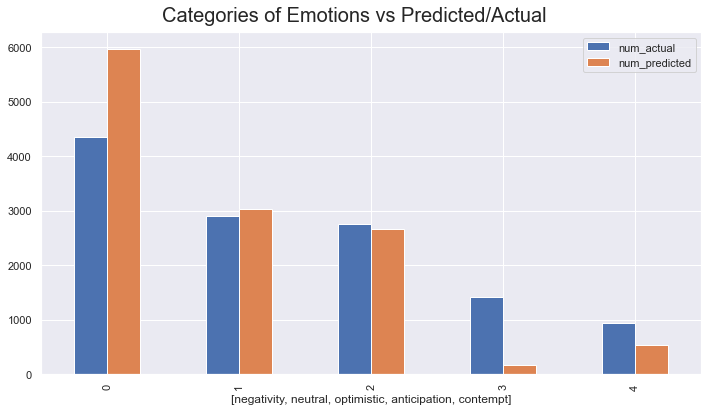

In [214]:
labels = ['negativity','neutral','optimistic','anticipation','contempt']
overall.plot(kind='bar',y=['num_actual','num_predicted'],  xlabel = labels, figsize=(10,6))
plt.gcf().tight_layout(rect=[0, 0.03, 1, 0.95])
plt.gcf().suptitle("Categories of Emotions vs Predicted/Actual",fontsize=20);

**Observations**
- We can see that class 3 (anticipation) is has a huge margin of error in its prediction, and most of them have not been accurately predicted. 
- The same was presented in Class 4 (contempt).
- However, we note that classes 3 and 4 were the least represented classes of emotions in our dataset. This is especially the case for Class 4 (contempt) where there are only 7.7% presence in our testing dataset. This also means that model could have been improved if the model has more data to train on.  
- There were many tweets that were predicted as "negativity" than what it should have been.
- It appears that classes 1 and 2 have been pretty accurately predicted, where both actual and predicted numbers rather similar. 

### Confusion Matrix
Determining the Misclassification of Emotions

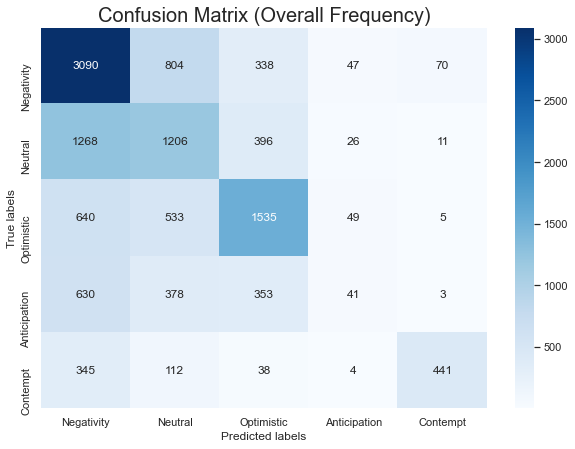

In [218]:
labels = ['Negativity','Neutral','Optimistic','Anticipation','Contempt']
cmatrix = confusion_matrix(y_test, y_pred_df['msg_emotion'])
plt.figure(figsize=(10,7))
ax= plt.subplot()
sns.heatmap(cmatrix, annot=True,annot_kws={"size": 12}, ax = ax,cmap='Blues',fmt='g');
sns.set(font_scale=1.0)
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix (Overall Frequency)',size=20); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

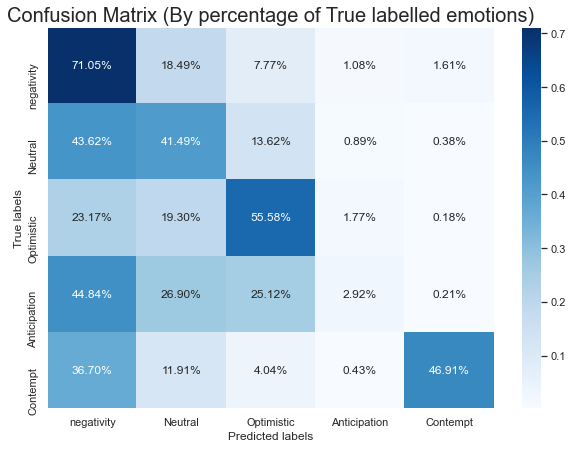

In [219]:
labels = ['negativity','Neutral','Optimistic','Anticipation','Contempt']
cmatrix = confusion_matrix(y_test, y_pred_df['msg_emotion'],normalize='true')
plt.figure(figsize=(10,7))
ax= plt.subplot()
sns.heatmap(cmatrix, annot=True,annot_kws={"size": 12}, ax = ax,cmap='Blues',fmt=".2%");
sns.set(font_scale=1.0)
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix (By percentage of True labelled emotions)',size=20); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

**Confusion Metrics Evaluation**
- From the above confusion matrix, we can conclude that Negativity has been classified the best (71% of actual negativity tweets have been correctly classified). 
- We are also satisfied with the classification efforts for Optimistic and Contempt tweets by our model, with 56% and 47% correctly classified. 
- Model performed the worst for Anticipation class, with only 3% of true labelled tweets have been classified correctly.
- Overall, it appears that many Negativity as an emotion class has been the 'go-to' class for most of the misclassified tweets.
    - However, another team of students from SUTD has also achieved similar results using the same tweet dataset for their multi-class classification model (through deep learning techniques). Hence, we believe this phenomenon of negativity misclassification might be due to the mislabelling of dataset.
    - [See Overview of Study](https://github.com/tlkh/text-emotion-classification). 
    

##### Negativity:
- For this class, a bulk of the wrongly predicted tweets fall in the Neutral category. 
- We also notice that a tiny portion of the Negativity class were misclassified as "Contempt", which accounts for 1.6% of total Negativity tweets. However, this 1.6% of class Negativity (which is 70 tweets in total) was much higher than the other classes of tweets that were misclassified (11, 5 and 3 tweets wrongly classified by the 3 other classes). This is notably significant given that "Contempt" category is the least represented in the dataset. 
- The misclassification from "Negativity" to "Optimistic" tweets also amounted to 357 tweets (7.7% of Negativity tweets). This is a cause of concern, and we have to further investigate.

##### Neutral:
- There appears to be a significant overlap between "Negativity" and "Neutral" tweets. A large proportion of the misclassified "Neutral" tweets were predicted to be in the "Negativity" class. We will further investigate this matter.
- Due to relabelling of our data (from original label 'relief' to 'neutral'), there were expectations that misclassification would occur in our predicted results. Believe that the 393 misclassified tweets from "neutral" to "optimistic" may arise, in part, due to the relabelling of data.

##### Optimistic:
- Results for this category appear to be fairly sound. 640 tweets (23% of Optimistic tweets) were unfortunately predicted to be in the "Negativity" class, which is a cause for concern. Another bulk that were misclassified falls into the 'Neutral' bucket, which is understandable and not a huge concern.

##### anticipation:
- Anticipation fared the worst amongst the lot. Anticipation tweets were an ensemble of previous labels including Fun, Surprise and Enthusiasm. Between the three, 'surprise' is the only category that may have a negative connotation to it. This was also observed in the word cloud in our previous notebook. 
- A bulk of anticipation tweets fall within Negativity, Neutral and Optimistic categories. 
- We will conduct further analysis on this problem.

##### Contempt:
- Prediction for 'Contempt' has been rather precise apart from misclassification into the Negativity class. 
- Contempt is seen to have been largely misclassified as 'negativity' (37% of Contempt tweets). As these two emotions fall along the same spectrum of emotions (exhibiting negativity), it is believed that this misclassification is justifiable. 

### Classification Report

In [220]:
print(classification_report(y_test, y_pred_df['msg_emotion']))
accuracy = accuracy_score(y_test, y_pred_df['msg_emotion'])
print(f'Accuracy Score: {round(accuracy,4)}')

              precision    recall  f1-score   support

           1       0.52      0.71      0.60      4349
           2       0.40      0.41      0.41      2907
           3       0.58      0.56      0.57      2762
           4       0.25      0.03      0.05      1405
           5       0.83      0.47      0.60       940

    accuracy                           0.51     12363
   macro avg       0.51      0.44      0.44     12363
weighted avg       0.50      0.51      0.48     12363

Accuracy Score: 0.5106


**Model Evaluation**
- Overall, our model performed approximately 16% better than than baseline, which yielded 35% accuracy. 
- A few metrics showed pleasant results: 
    - Contempt (Class 5): High precision - out of all tweets predicted to be 'contempt', 83% of them are in actuality, classified as 'contempt'.
    - Contempt (Class 5): Moderately High F1-Score - F1 score of 0.6.
    - Negativity (Class 1): High recall - out of all tweets labelled as 'negativity', 71% have been predicted to correctly.
    - Negativity (Class 1): Moderately high F1 Score of 0.6
    - Optimistic (Class 3): Across the board, 'optimistic' has performed fairly well with precision, recall and F1 score in excess of ±55%.

### ROC-AUC Curve

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

AUC is an effective way to summarize the overall diagnostic accuracy of the test. It takes values from 0 to 1, where a value of 0 indicates a perfectly inaccurate test and a value of 1 reflects a perfectly accurate test. AUC can be computed using the trapezoidal rule.3 In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding

[Source: Jayawant N.Mandrekar, PhD](https://www.sciencedirect.com/science/article/pii/S1556086415306043#:~:text=AREA%20UNDER%20THE%20ROC%20CURVE,-AUC%20is%20an&text=In%20general%2C%20an%20AUC%20of,than%200.9%20is%20considered%20outstanding.)

Code below inspired by: [Stackoverflow](https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification)

In [221]:
y_bin = label_binarize(y_test['msg_emotion'].values, classes=[1, 2, 3, 4, 5])
n_classes = y_bin.shape[1]

In [222]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], gs_2.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','pink','purple'])

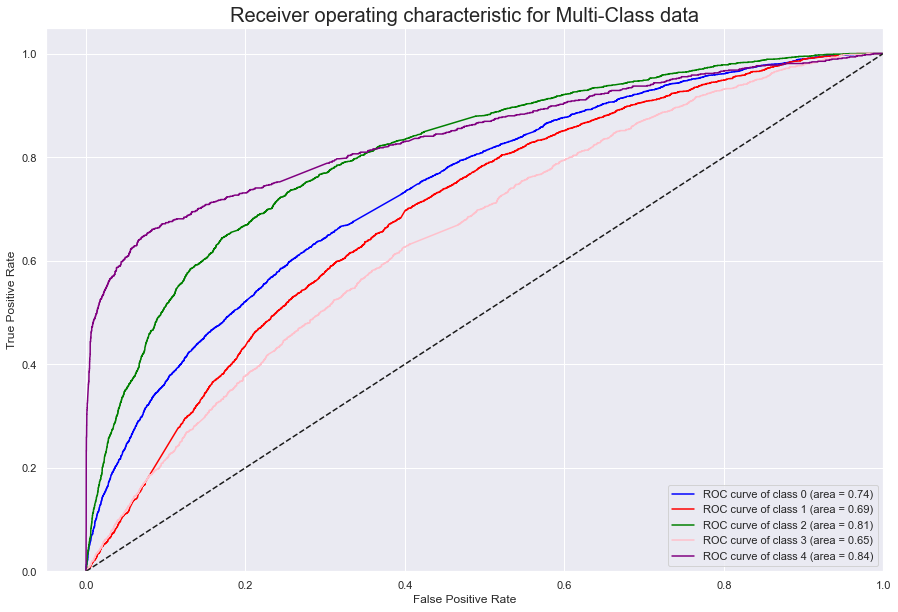

In [223]:
plt.figure(figsize=(15,10))
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Multi-Class data',size=20)
plt.legend(loc="lower right")
plt.show()

In [224]:
roc_auc_score(y_test['msg_emotion'].values, gs_2.predict_proba(X_test),multi_class='ovo')

0.756160555800445

**Observations: ROC-AUC Curve**

Results complement with the report generated from the Classification Report above. 
- Class 4 (Contempt) exhibits the greatest area under the curve of 0.84. This means that it is highly effectly in predicting the emotion of tweets, out of all tweets predicted as "contempt".
- Class 1 (Neutral) and 3 (Anticipatory) fared the worst amongst the 5 classes. ROC area under the curve is at 0.69 and 0.65. 
    - The excerpt above by Jayawant N.Mandrekar, PhD, noted that a score above 0.7 would be considered 'acceptable'.
    - This essentially means that our predictive ability for "Neutral" and "Anticipatory" can be further improved on.

# Understanding Model Results

In [225]:
best_model.steps

[('union',
  FeatureUnion(transformer_list=[('content',
                                  Pipeline(steps=[('selector',
                                                   FunctionTransformer(func=<function <lambda> at 0x1a271d4a70>)),
                                                  ('vectorizer',
                                                   CountVectorizer(max_features=6500,
                                                                   min_df=10,
                                                                   ngram_range=(1,
                                                                                2)))])),
                                 ('punc_len',
                                  Pipeline(steps=[('selector',
                                                   FunctionTransformer(func=<function <lambda> at 0x1a271d4b90>)),
                                                  ('scaler', RobustScaler())]))])),
 ('classifier_lr', LogisticRegression(C=0.1))]

In [226]:
# Coefficients of all my features
coef = best_model[1].coef_
print(coef.shape)
coef[:10]

(5, 2769)


array([[-0.23794832,  0.08615181,  0.05749914, ..., -0.05321624,
         0.03050909,  0.13770883],
       [-0.0639118 , -0.02505477,  0.11708734, ..., -0.17658748,
         0.03871465, -0.03311854],
       [ 0.0277552 ,  0.05725075, -0.07403171, ...,  0.11222087,
        -0.16173777, -0.0769459 ],
       [ 0.06746194, -0.02668981, -0.04305774, ...,  0.1022117 ,
         0.07936899,  0.01985827],
       [ 0.20664298, -0.09165798, -0.05749702, ...,  0.01537115,
         0.01314504, -0.04750266]])

In [227]:
# Extracting the selected features from our Vectorizer. It has been reduced to only 2766 unique terms. 
# Indeed, there are 3 less features compared to the shape above (2769). This corresponds to the 3 punctuation columns we have.
word_features = best_model['union'].transformer_list[0][1]['vectorizer'].get_feature_names()
len(word_features)

2766

In [228]:
# A random sample of the word features to see the quality of our features
print(word_features[1000:1050])

['gonna', 'gonna make', 'gonna miss', 'good', 'good home', 'good idea', 'good job', 'good know', 'good luck', 'good mood', 'good morning', 'good movie', 'good news', 'good night', 'good stuff', 'good thanks', 'good thing', 'good time', 'good way', 'good weekend', 'good work', 'goodbye', 'goodmorning', 'goodness', 'goodnight', 'google', 'gorgeous', 'gosh', 'gossip', 'gotta', 'gotta love', 'gotta work', 'gotten', 'gr8', 'grab', 'grace', 'grad', 'grade', 'graduate', 'graduation', 'grand', 'grandma', 'grandpa', 'grandparent', 'grateful', 'gray', 'great', 'great mother', 'great night', 'great time']


All sampled words seems to be of decent quality. Most words do carry a form of emotion. 
- ie. 'gossip': negative
- ie. 'grandma','grandpa': optimistic (love)
- ie. 'great','gr8','good','good luck','good job','good morning': optimistic

In [229]:
# Ensuring that the content_final's countvectorizers go first before punctuation columns.
X.head()

,content_final,len_exc,len_qn,len_ellip
0,know listenin bad habit earlier started freakin,0,0,0
1,layin n bed headache ughhhh waitin,0,0,2
2,funeral ceremony gloomy friday,0,0,2
3,hang friend soon,1,0,0
4,trade ha houston ticket,0,0,0


In [230]:
word_features.append("len_exc")
word_features.append("len_qn")
word_features.append("len_ellip")

In [241]:
# Check if the three punctuation featuers have been included.
print(word_features[-100:])

['wit', 'wk', 'wknd', 'woke', 'woken', 'wolverine', 'woman', 'won', 'wonder', 'wonderful', 'wonderful mother', 'wondering', 'wont', 'wont able', 'wont work', 'woo', 'woo hoo', 'woohoo', 'woop', 'woot', 'word', 'wore', 'work', 'work till', 'work today', 'work tomorrow', 'work week', 'work weekend', 'work work', 'worked', 'workin', 'working', 'workout', 'world', 'worried', 'worry', 'worse', 'worst', 'worth', 'wouldnt', 'wow', 'wow thats', 'wrap', 'write', 'writer', 'writing', 'wrong', 'wrote', 'wtf', 'xbox', 'xd', 'xo', 'xoxo', 'xx', 'xxx', 'xxxx', 'yah', 'yahoo', 'yall', 'yard', 'yay', 'yea', 'yeah', 'yeah know', 'year', 'year ago', 'year old', 'yeh', 'yellow', 'yep', 'yer', 'yes', 'yes yes', 'yesterday', 'yo', 'york', 'youd', 'youll', 'young', 'younger', 'youre', 'youre going', 'youre having', 'youre right', 'youre welcome', 'youtube', 'youve', 'yr', 'yum', 'yummy', 'yup', 'zombie', 'zoo', '½m', '½s', '½t', '½ï', 'len_exc', 'len_qn', 'len_ellip']


In [232]:
# Check shape of our coefficient array
coef.shape

(5, 2769)

In [233]:
len(word_features)

2769

In [234]:
dataframe = pd.DataFrame(data=word_features,columns=['word'])

In [235]:
dataframe

,word
0,00
1,000
2,09
3,10
4,10 minute
...,...
2764,½t
2765,½ï
2766,len_exc
2767,len_qn


In [236]:
len(coef[0])

2769

In [243]:
dataframe['Negativity'] = coef[0]
dataframe['Neutral'] = coef[1]
dataframe['Optimistic'] = coef[2]
dataframe['Anticipation'] = coef[3]
dataframe['Contempt'] = coef[4]

In [244]:
dataframe

,word,negativity,Neutral,Optimistic,Anticipation,Contempt,Negativity
0,00,-0.237948,-0.063912,0.027755,0.067462,0.206643,-0.237948
1,000,0.086152,-0.025055,0.057251,-0.026690,-0.091658,0.086152
2,09,0.057499,0.117087,-0.074032,-0.043058,-0.057497,0.057499
3,10,-0.075362,-0.030549,-0.153636,0.034025,0.225522,-0.075362
4,10 minute,-0.062269,0.065079,-0.009827,-0.002304,0.009321,-0.062269
...,...,...,...,...,...,...,...
2764,½t,-0.080590,0.135481,0.017721,-0.127805,0.055193,-0.080590
2765,½ï,-0.115460,0.106692,-0.066302,-0.036031,0.111101,-0.115460
2766,len_exc,-0.053216,-0.176587,0.112221,0.102212,0.015371,-0.053216
2767,len_qn,0.030509,0.038715,-0.161738,0.079369,0.013145,0.030509


## Top contributing words for each emotion class

In [245]:
def emotion_barplot(emotion):
    plt.figure(figsize=(10,8))
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
    sns.barplot(data=dataframe.sort_values(by=emotion,ascending=False).head(20)[['word',emotion]],y='word',x=emotion,palette="rocket")
    plt.title(f"Top Contributing Words for {emotion} tweets")
    plt.show()

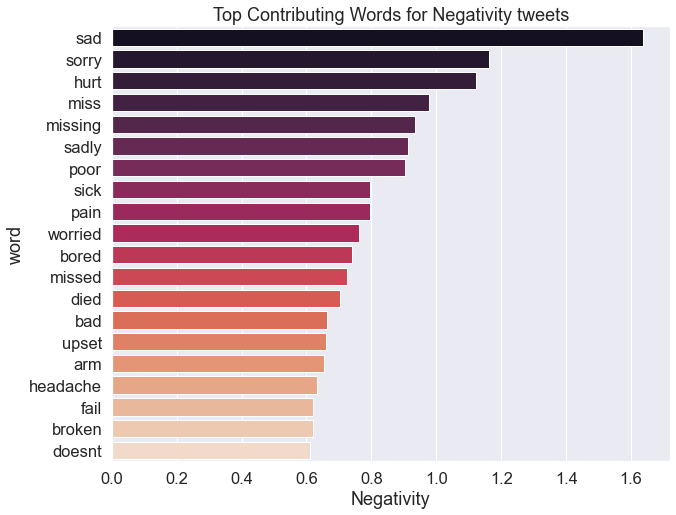

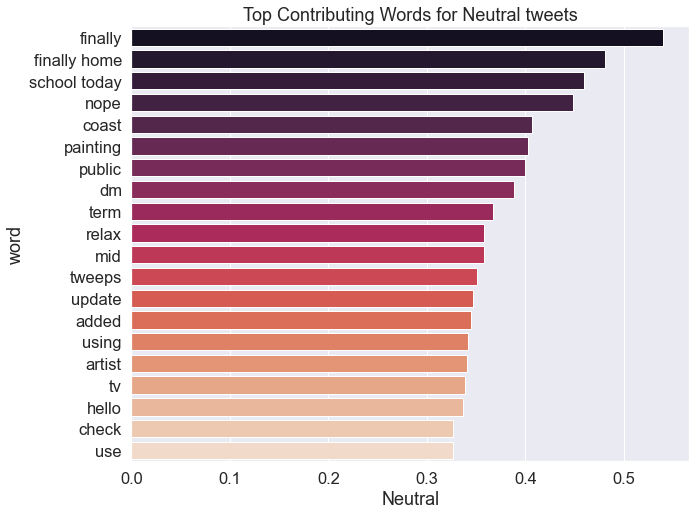

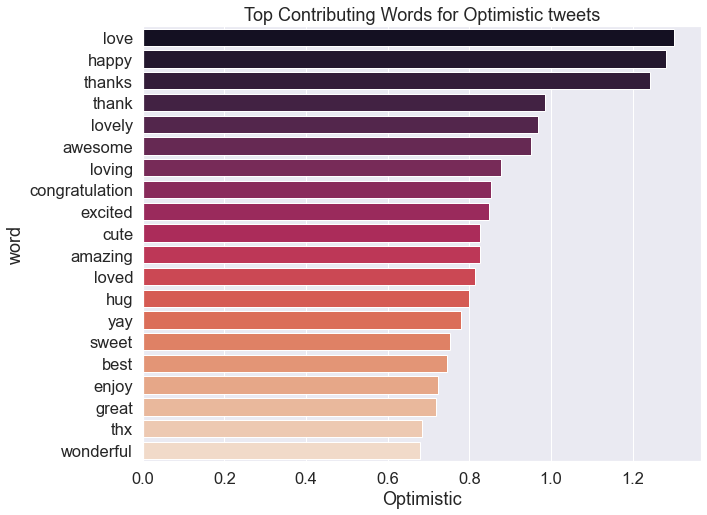

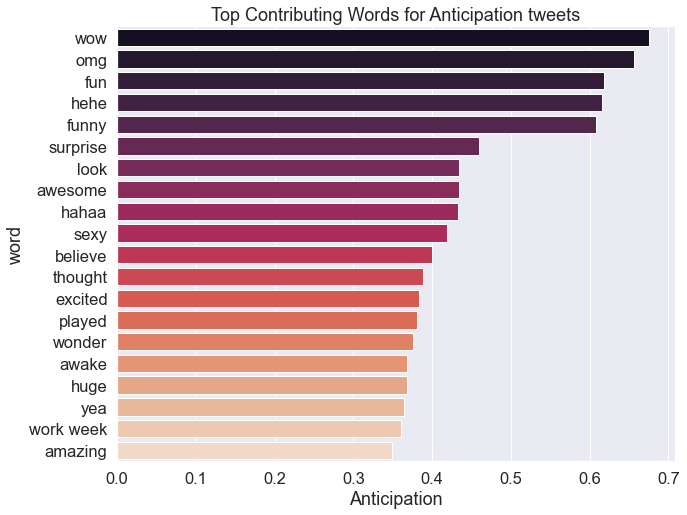

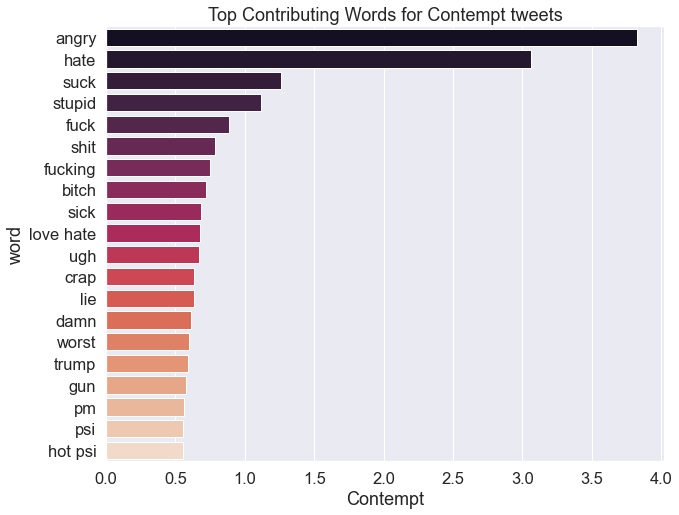

In [246]:
emotion_barplot('Negativity')
emotion_barplot('Neutral')
emotion_barplot('Optimistic')
emotion_barplot('Anticipation')
emotion_barplot('Contempt')

**Observations:**

Top contributing words for all categories except "Neutral" are very indicative of the classified emotions.
- Negativity: 'sad','miss','sorry','poor','sick','died' - All terms are heavily associated with negatvitiy. In fact, many of the health related words are associated with negativity.
- Optimistic: Many variations of the word 'love' were present. Also, it appears that 'thanking' people is heavily associated with the optimistic class of emotions. 
- Anticipation: Contributing words appear to be very lively and active in nature: 'fun','omg','excited','surprised'. These are also very indicative of the element of 'excitement' that is present in the anticipatory emotion class.
    - However, as we observe the max. coefficient of the top contributing words, they are very small as compared to the other three classes (Optimistic, negativity and Contempt). This shows that our model could not predict the Anticipation class well. 
- Contempt: Highly negative class beyond the existing 'negativity' emotion class. This class represents resentment and hatred. Indeed, words that contributed most to the class are: 'angry','hate','stupid','suck' and some other vulgarities.
- Neutral: The catch-all class (ie. 'others') for tweets that cannot be well classified to other emotion classes, this class includes many terms that appear to be a random mix of topics. 
    - Importantly, we look at the max. coefficient that is contributed by words in Neutral. The maximum is approximately 1.3, which is way lower than other classes like Optimistic, negativity and Contempt. 

## Effect of Punctuation on Tone of tweet

In [247]:
dataframe

,word,negativity,Neutral,Optimistic,Anticipation,Contempt,Negativity
0,00,-0.237948,-0.063912,0.027755,0.067462,0.206643,-0.237948
1,000,0.086152,-0.025055,0.057251,-0.026690,-0.091658,0.086152
2,09,0.057499,0.117087,-0.074032,-0.043058,-0.057497,0.057499
3,10,-0.075362,-0.030549,-0.153636,0.034025,0.225522,-0.075362
4,10 minute,-0.062269,0.065079,-0.009827,-0.002304,0.009321,-0.062269
...,...,...,...,...,...,...,...
2764,½t,-0.080590,0.135481,0.017721,-0.127805,0.055193,-0.080590
2765,½ï,-0.115460,0.106692,-0.066302,-0.036031,0.111101,-0.115460
2766,len_exc,-0.053216,-0.176587,0.112221,0.102212,0.015371,-0.053216
2767,len_qn,0.030509,0.038715,-0.161738,0.079369,0.013145,0.030509


In [248]:
dataframe.describe()

,negativity,Neutral,Optimistic,Anticipation,Contempt,Negativity
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000
mean,0.011738,-0.030487,-0.005719,0.004842,0.019626,0.011738
std,0.173665,0.142699,0.175739,0.123929,0.163443,0.173665
min,-1.023990,-1.052396,-1.102509,-0.802046,-0.518962,-1.023990
25%,-0.089968,-0.114424,-0.105731,-0.079815,-0.053448,-0.089968
50%,-0.003694,-0.028981,-0.022440,-0.007370,-0.010037,-0.003694
75%,0.100733,0.057992,0.081394,0.076533,0.068495,0.100733
max,1.637098,0.539750,1.301344,0.674669,3.828040,1.637098


In [249]:
punc_df = dataframe.loc[(dataframe['word']=='len_exc') |(dataframe['word']=='len_qn') | (dataframe['word']=='len_ellip'),:]
punc_df

,word,negativity,Neutral,Optimistic,Anticipation,Contempt,Negativity
2766,len_exc,-0.053216,-0.176587,0.112221,0.102212,0.015371,-0.053216
2767,len_qn,0.030509,0.038715,-0.161738,0.079369,0.013145,0.030509
2768,len_ellip,0.137709,-0.033119,-0.076946,0.019858,-0.047503,0.137709


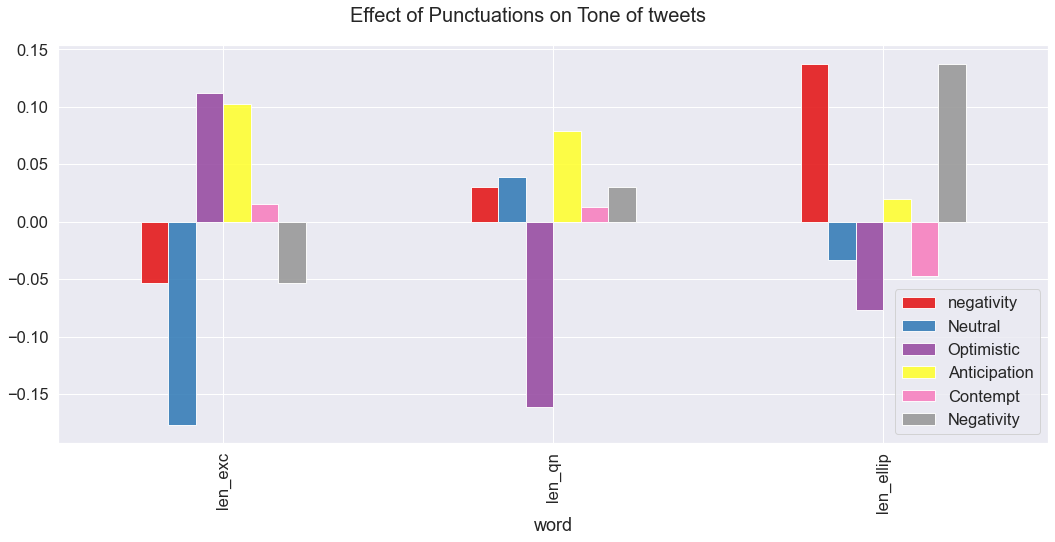

In [250]:
plt.rcParams["figure.figsize"] = [15, 8]
punc_df.plot(kind='bar',x='word',alpha=0.9,colormap='Set1') #colormap='Greens'   #
plt.gcf().tight_layout(rect=[0, 0.03, 1, 0.95])
plt.gcf().suptitle("Effect of Punctuations on Tone of tweets",fontsize=20);
plt.legend();

In [251]:
dataframe.mean()

negativity      0.011738
Neutral        -0.030487
Optimistic     -0.005719
Anticipation    0.004842
Contempt        0.019626
Negativity      0.011738
dtype: float64

**Observations**
Emotions of 

Number of Exclamation marks ('!')
- We observe that there is a relationship between the absence of exclaimation marks with negativity and neutral tweets.
- However, it appears that exclamation marks are highly correlated to the optimistic and anticipation tweets. The coefficient contribution for these two categories by presence of exclamation marks have way exceeded the mean coefficient for the two classes. (ie. Optimistic: contribution by exclaimation mark at 0.120 vs. mean of 0.041).

Number of Question marks ('?')
- Overall, compared to the two other kinds of punctuations we have modelled for, question marks contributed the least to our coefficients across all five classes. 
- There is a slight positive correlation between number of question marks and Anticipation tweets, with coefficient contribution exceeding the mean (0.065 contribution vs 0.004 mean)
- There is also a slight negative correlation between number of question marks and Contempt tweets, which is an interseting observation.

Sets of ellipsis ('...')
- The ellipsis has shown to be a rather strong predictor for classifying tweet emotions.
- The ellipsis has a high positive correlation to tweets that were labelled 'negativity'.
    - 0.14 contribution vs 0.04 mean
- The ellipsis has a negative correlation to neutral tweets, as well as optimistic and anticipatory (in descending order of importance).

# Understanding Misclassification: Deeper Dive into tweets

![image](../data/image/emotionwheel.png)

### Qualitative Assessment of our Model: *Going beyond Accuracy scores*
There are some tweets that may have been misclassified, but might not be of great cause for concern. 
We have to judge them base on the spectrum of emotions - whether emotions are closely related to each other.
For example, negativity (ie. pensiveness/boredom which are depicted by blue and purple) is right next to contempt/annoyance. Hence, a negativity-contempt/contempt-negativity misclassification is not a big cause for concern.

However, optimism, which is a crossover between serendipity and interest, is polar opposite to pensiveness/distraction (negativity). Hence, an optimistic-negativity/ negativity-optimistic misclassification is a serious issue. 

Note that 'surprise' is adjacent to 'sadness' in the emotion wheel. Indeed, surprise has a dual meaning to it - it could be both pleasant or negativity. However, based on our word cloud, we have relabelled our 'surprise' tweets as 'anticipation'. One of the reasons behind this was also because originally labelled 'surprised' tweets were  a really small proportion. Hence, we believe it will not affect our results drastically. 

Anticipation is an emotion that belong to the 'orange' section of the emotion wheel, beside joy and anger. Hence, anticipation, being a close cousin to both, has a huge margin of error to begin with. 

**A few aspects we hope to investigate:**
- Misclassified negativity tweets to "Optimistic", "Neutral" and Contempt
- Misclassified Neutral tweets to "Contempt"
- Misclassified Optimistic tweets to "negativity" and "Neutral"
- Misclassified Anticipation tweets to "Optimistic","negativity" and "Neutral"
- Misclassified Contempt tweets to "Optimistic" and "negativity"

In [252]:
df.head()

,msg_emotion,content,content_final,len_exc,len_qn,len_ellip,predicted_emotion
0,negativity,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin,0,0,0,negativity
1,negativity,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhh waitin,0,0,2,negativity
2,negativity,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,0,0,2,negativity
3,anticipation,wants to hang out with friends SOON!,hang friend soon,1,0,0,neutral
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade ha houston ticket,0,0,0,negativity


In [253]:
df_analysis = df

In [254]:
df_analysis['predicted_emotion'] = best_model.predict(df.drop(columns='msg_emotion'))
df_analysis.head()

,msg_emotion,content,content_final,len_exc,len_qn,len_ellip,predicted_emotion
0,negativity,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin,0,0,0,1
1,negativity,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhh waitin,0,0,2,1
2,negativity,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,0,0,2,1
3,anticipation,wants to hang out with friends SOON!,hang friend soon,1,0,0,2
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade ha houston ticket,0,0,0,2


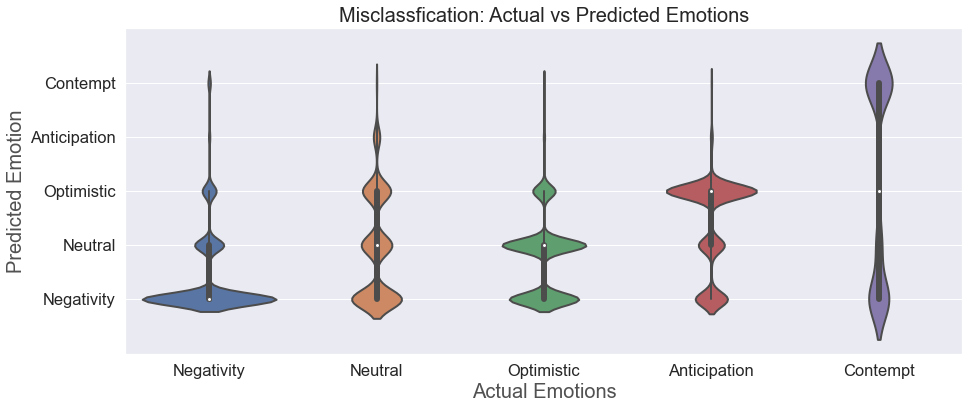

In [255]:
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.violinplot(x="msg_emotion", y="predicted_emotion",  data=df,)
ax.set_xlabel("Actual Emotions",size = 20,alpha=0.8)
ax.set_ylabel("Predicted Emotion",size = 20,alpha=0.8)
ticks_x = [0,1, 2, 3, 4]
labels_x = ["Negativity", "Neutral", "Optimistic",'Anticipation','Contempt']
ticks_y = [1,2,3,4,5]
plt.xticks(ticks_x, labels_x)
plt.yticks(ticks_y,labels_x)
ax.set_title("Misclassfication: Actual vs Predicted Emotions",size=20);

Visual check on misclassification using a violin plot.
- We can see that class 4 (anticipation) has been classified to 1 (negativity), 2 (neutral), 3 (optimistic) more frequently than the actual class 4 itself.
- For class 5 (contempt), misclassification to class 1 (negativity) is more common. 
- For class 2 (neutral), there are more tweets classified into class 1 (negativity) than class 3 (optimistic).
- Overall, misclassification towards classes 4 (anticipation) and 5 (contempt) is minimal.

In [256]:
dict_emo_swap = dict([(value, key) for key, value in dict_emo.items()]) 
dict_emo_swap

{1: 'negativity',
 2: 'neutral',
 3: 'optimistic',
 4: 'anticipation',
 5: 'contempt'}

In [257]:
df_analysis['msg_emotion'].replace(dict_emo_swap,inplace=True)
df_analysis['predicted_emotion'].replace(dict_emo_swap,inplace=True)

In [258]:
df_analysis.head()

,msg_emotion,content,content_final,len_exc,len_qn,len_ellip,predicted_emotion
0,negativity,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin,0,0,0,negativity
1,negativity,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhh waitin,0,0,2,negativity
2,negativity,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,0,0,2,negativity
3,anticipation,wants to hang out with friends SOON!,hang friend soon,1,0,0,neutral
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade ha houston ticket,0,0,0,neutral


In [259]:
def compare_emotions(actual,predicted,sample_size,rs=23):
    analyse = df_analysis[(df_analysis['msg_emotion']==actual) & (df_analysis['predicted_emotion']==predicted)]
    return analyse[['msg_emotion','predicted_emotion','content','content_final']].sample(sample_size,random_state=rs)

### Misclassified tweets for negativity

##### Correctly labelled negativity Tweets

In [260]:
compare_emotions('negativity','negativity',10,rs=123)

,msg_emotion,predicted_emotion,content,content_final
20796,negativity,negativity,@stephaniehealy Past experiences of being a redhead (eg. discrimination) or even just general info bout gingers in society! It all helps,past experience redhead discrimination general info bout ginger society help
17939,negativity,negativity,@selenagomez aww but we miss you here in the USA.,aww miss usa
454,negativity,negativity,Somebody please save the polar bears!,somebody save polar bear
13640,negativity,negativity,Awww that lil girl on bgt :'( when they said she didnt have time :'( that was soo sad and them huggin her,awww lil girl bgt said didnt time soo sad huggin
2804,negativity,negativity,sick n tired of people who steal other people's work,sick n tired people steal people work
27442,negativity,negativity,@sarahjlwest I ake it you're at work then and not lazing at home on a sunny bank holiday.,ake youre work lazing home sunny bank holiday
15149,negativity,negativity,"Watching GH. I feel so bad for Carly. OMG, so fucked up.",watching gh feel bad carly omg fucked
7062,negativity,negativity,@kate38381849 ouuhh dont cry i feel so sad right now,ouuhh dont feel sad right
8283,negativity,negativity,On my way to lake geneva and I miss my laura,way lake geneva miss laura
39865,negativity,negativity,@watermelon39 haha! And Twitter! Hard though isn't it?!,twitter hard isnt


#####  Misclassified negativity Tweets

In [261]:
compare_emotions('negativity','neutral',10,rs=27)

,msg_emotion,predicted_emotion,content,content_final
15869,negativity,neutral,@OfficialBB Will we be able to see clips/episodes on the C4 website from America? Or will I languish reading the news stories again?,able clip episode c4 website america languish reading news story
35962,negativity,neutral,"@bubbalou1969 Morning Lou, I Have some housework to do then im off to Church",morning lou housework church
34177,negativity,neutral,@poopiesanchez in clearwater,clearwater
1109,negativity,neutral,wants to go home.,home
14603,negativity,neutral,@AKDB Tell me about it,tell
10681,negativity,neutral,it's summer time.... these gas prices are going up again,summer time gas price going
2201,negativity,neutral,"@xBellaMariex Hello Bella, why r you going to delete your account..?",hello bella r going delete account
19848,negativity,neutral,@sarahbellafina I'll try but silly silly tweetdeck being mean to me again,ill try silly silly tweetdeck mean
29370,negativity,neutral,"John, are you sure we aren't mtb?",john arent mtb
28677,negativity,neutral,@GregInsco thats another sponsor,thats sponsor


Overall, the negativity-neutral misclassification is not as big of a concern as compared to the negativity-optimistic misclassification.

However, we note that human intonations and interpretation is extremely important in emotion recognition, and there are areas that machines may not be able to learn despite great efforts in this field.

- Example: #10681: 'it's summer time.... these gas prices are going up again'
    - From a machine's point of view, none of these word appear to be negative. However, as we understand that 'gas prices' and 'going up' would lead to a negative outcome for our quality of life, this requires additional training of our model that may be rather complex for our current operations. 

Moreover, some tweets do not exactly point towards a 'negativity' emotion class, such as the two examples below.
- Example: #1109: wants to go home.
- Example: #14603: @AKDB Tell me about it	
In conclusion, Negativity-Neutral misclassification were largely a result of mislabelling and the lack of human interpretation behind words that seem 'neutral'.

In [276]:
compare_emotions('negativity','optimistic',10,rs=23)

,msg_emotion,predicted_emotion,content,content_final
17818,negativity,optimistic,@mitchelmusso i would love to call you but i live in Norway so its a little hard,love live norway little hard
21295,negativity,optimistic,"@danielleg1709 hahaha this is super late, but thank you!!",super late thank
38530,negativity,optimistic,@F1TailPipe_com Thanks,thanks
36043,negativity,optimistic,Off to enjoy a Hanami picnic at the cherry tree park. Hope the weather stays nice.,enjoy hanami picnic cherry tree park hope weather stay nice
11821,negativity,optimistic,Loved the sun today. Did not love a black suit and black top plus 6 trains/tubes to get to my meeting and back Need to shop for summer,loved sun today love black suit black plus 6 train tube meeting need shop summer
30924,negativity,optimistic,@BPDINOKC Thanks!,thanks
12189,negativity,optimistic,"Oh..Summer begins..yay.. The fighting, Crying and stress has started with the kids..It's only been 3 hrs since they got out.",summer begin yay fighting stress ha started kid 3 hr
28642,negativity,optimistic,ok shopping was far too fun ~ unpacking the bags now,shopping far fun unpacking bag
35080,negativity,optimistic,"@SirReigns Good luck with the design....remember the little people Heading to bed, goodnight!",good luck design remember little people heading bed goodnight
39192,negativity,optimistic,Happy mothers day Mummy ?,happy mother mummy


This form of misclassification should have a higher penalty given that they are polar opposites on the emotion spectrum.

Judging by the few tweets that were sampled, it appears that tweet emotion labelled by the manual annotators might have been misclassified. Some of these tweets actually do exhibit positivity, despite being labelled as negativity. 
- Example: #39192: "Happy mothers day Mummy ?"
- Example: #24704: "@danielleg1709 hahaha this is super late, but thank you!!"
- Example #11821" "Loved the sun today. Did not love a black suit and black top plus 6 trains/tubes to get to my meeting and back Need to shop for summer"

Nearly all the results above, including the 3 tweets I have described above as examples, appear to be mislabelled. These three tweets strongly exhibit a 'happy' vibe, which ought to be labelled as 'optimistic'. 

In conclusion, the negativity-optimistic misclassification, based on the above 10 samples, appears to be highly related to the mislabelling of data.

In [263]:
compare_emotions('negativity','contempt',10,rs=27)

,msg_emotion,predicted_emotion,content,content_final
3168,negativity,contempt,"@KINGmoney yep and its freezing, i hate winter im literally wearing blackets",yep freezing hate winter literally wearing blackets
851,negativity,contempt,feels like crap whenever she lays down. @)(1+-'$#! I hate heartburn &amp; backaches!,feel like crap lay hate heartburn backache
15803,negativity,contempt,i hate when i paint my nails because then i cant suck my thumb because it tastes bad,hate paint nail suck thumb taste bad
2800,negativity,contempt,I hate the &quot;out-of-nowhere&quot; stuff...,hate stuff
6625,negativity,contempt,Phooey! They've planned CAMPING for my class reunion. I. Hate. Camping. ...and being the only single girl left from my graduating class.,phooey theyve planned camping class reunion hate camping single girl left graduating class
4807,negativity,contempt,"@_Janet_ ouch, I hate it when favourite items of clothing get ruined.",ouch hate favourite item clothing ruined
24936,negativity,contempt,@sensualbodyrubs Hope you get your car today Hate anything that stops me from my work ;),hope car today hate stop work
12299,negativity,contempt,@BeansOnToasted NOOOOO I hate traffic,hate traffic
5208,negativity,contempt,really hates delayed trains especially 44 minute delayed trains. Now going to be late for work,hate delayed train especially 44 minute delayed train going late work
22257,negativity,contempt,@claudiatan http://twitpic.com/4jber - aww .... then we wonder why they hate us later..... lol!!,aww wonder hate u later


The misclassification from negativity to contempt is not a big concern, as both are relatively similar emotion. The difference between them is that contempt appears to carry more vengence and anger, whilst negativity carries more heaviness and melancholy. 

Judging by the few tweets sampled, indeed, tweets appear to exhibit anger on top of melancholy. Words that appear frequently in misclassified text was "hate" (7/10), "suck" (2/10) and some vulgarities. These tweets could have been better labelled to be in the 'contempt' class instead. Hence, I believe that the model is still decently sound in this regard.

### Misclassified tweets for Neutral

##### Correctly labelled neutral Tweets

In [264]:
compare_emotions('neutral','neutral',10,rs=123)

,msg_emotion,predicted_emotion,content,content_final
32253,neutral,neutral,@msmissy two. Just going to visit someone,going visit
38116,neutral,neutral,Come See Me Live On Stickam http://www.stickam.com/valentine_rock,come live stickam
20210,neutral,neutral,is debating giving twitter a proper go. now to try and understand it,debating giving twitter proper try understand
11346,neutral,neutral,i am talkin on da phone and typin at da same time,talkin da phone typin da time
28820,neutral,neutral,@babycakes1966 i agree,agree
20559,neutral,neutral,@Liesbetje with your bicycle?,bicycle
22679,neutral,neutral,tino hat ne wii,tin hat
6145,neutral,neutral,I am dreading shopping for a swimsuit,dreading shopping swimsuit
24555,neutral,neutral,@jeffsgrippen it gets down to like 10C at night and about 25C in the day,like 10c night 25c
36931,neutral,neutral,COTTIN WITH EMILYYYYYYYY,cottin emilyyyyyyyy


#####  Misclassified neutral Tweets

In [288]:
compare_emotions('neutral','negativity',10,rs=53)

,msg_emotion,predicted_emotion,content,content_final
28808,neutral,negativity,looking at all my old myspace status' oh mann. Skyrockets in flight! afternoon delight! AAAAAAAAfternoon delight!,looking old myspace status mann skyrocket flight afternoon delight aaaaaaaafternoon delight
14893,neutral,negativity,Turn over report...done,turn report
12681,neutral,negativity,We are checking out and on our way home I am rwady to be home!,checking way home rwady home
37272,neutral,negativity,Trip to the zoo today,trip zoo today
10694,neutral,negativity,Im so tired. And its so gloomy what happeened ro summer?,tired gloomy happeened ro summer
4706,neutral,negativity,@crazycori713 I don't think I'm going camping,dont think going camping
19072,neutral,negativity,Im lonely werkin,lonely werkin
14824,neutral,negativity,@jspatton: sorry forgot that,sorry forgot
32352,neutral,negativity,"@metodico &quot;organization ...ITIL, forget about people (and so they fail)&quot; preaching to the converted IT is the people http://tr.im/kWUA",organization itil forget people fail preaching converted people
17896,neutral,negativity,i really miss my satan kitty,miss satan kitty


The neutral-negativity misclassification is not a big cause for concern. However, we understand from the confusion matrix that the neutral-negativity pair were the most highly misclassified of all emotion pairs. 

It appears that our model overweighs some of 'negative' words like 'miss','sorry','dont think'. These tweets in itself appears to be rather neutral. 

The model could definitely do better in predicting these tweets. The reason behind the high rate of misclassification may lie in the mislabelling of 'negativity' tweets as well as the insufficient cleaning with regards to that class.

In [265]:
compare_emotions('neutral','contempt',10,rs=27)

,msg_emotion,predicted_emotion,content,content_final
6551,neutral,contempt,I hate today.,hate today
32824,neutral,contempt,@MyShellMeishel Icky bitches piss me off. I am sooo glad you arent an icky bitch!,icky bitch piss sooo glad arent icky bitch
19201,neutral,contempt,i hate my presentation hahah whatever im glad its over,hate presentation hahaa glad
9910,neutral,contempt,"@bhamboxset I saw them at a show a few weeks ago. Hate to say I was not all that impressed fun. and AS were good, though.",saw week ago hate say impressed fun good
13712,neutral,contempt,There's Only One Thing I Hate About Friends And Dats When They Move Skl They Forget About Yuu,thing hate friend dat skl forget yuu
7524,neutral,contempt,fuck i hate when the strawberries run out in my special K,fuck hate strawberry run special k
24861,neutral,contempt,"Jamie @ Sean Cody, up for some angry sex?: Jamie @ Sean Cody, I wouldn't piss this one off Hey there Guys, Do.. http://tinyurl.com/ddyyd6",jamie sean cody angry sex jamie sean cody wouldnt piss guy
15671,neutral,contempt,Is about to start stupid chores!!!! Ewww.... stupid chores!!!!,start stupid chore e stupid chore
4548,neutral,contempt,No u guys! @jonathanrknight said California in an angry tweet to perez hilton! Jonathan was so upset he spelled California wrong,u guy said california angry perez hilton jonathan upset spelled california wrong
33330,neutral,contempt,Looks like i can go see jeffree star afterall. I told my dad he'd hate the music &amp; he said i could go alone,look like jeffree star afterall told dad hed hate music said


One of the bigger concerns for misclassification of 'neutral' is for tweets to be predicted to be 'contempt', as 'contempt' is on a deeper end of the spectrum compared to 'negativity'. 
The key words that appeared in this neutral-contempt misclassification are 'hate','piss','stupid' and some vulgarities. 

These were individual tweets that were chosen as part of the NLP study. However, in reality, these tweets might be part of a larger conversation between friends. In that case, they might appear to be 'neutral'. However, individually, these tweets do exhibit a strong negativity and resentment, with heavy terms thrown (hate, angry, bitch etc.). 

Hence, I believe that the model is still decent in predicting the emotions of these tweets.

### Misclassified tweets for Optimistic

##### Correctly labelled optimistic Tweets

In [266]:
compare_emotions('optimistic','optimistic',10,rs=123)

,msg_emotion,predicted_emotion,content,content_final
37803,optimistic,optimistic,munchin BACON BUTTIES! woohoo!! my faves!!!,munchin bacon butty woohoo faves
35446,optimistic,optimistic,@stuntazian I still have them!! Yay! Gonna eat some now,yay gonna eat
4867,optimistic,optimistic,I just made myself a wonderful breakfast!!!!!!!! Now I have to get ready to workout,wonderful breakfast ready workout
34096,optimistic,optimistic,@dinno thanks dinno appreciate it,thanks dinno appreciate
37995,optimistic,optimistic,@camilleprats Happy Mother's Day!,happy mother
22509,optimistic,optimistic,@sunshinebliss it was ok. Cute @ times.,cute time
22676,optimistic,optimistic,"Sittin at home, hellllllllsssssss yeah Got the girrrrrl, the boysssss &amp; 2 mangy cats, this is a good time in my life. Goodnight twitter",sittin home hellllllllsssssss yeah girrrrrl boy 2 mangy cat good time life goodnight twitter
29839,optimistic,optimistic,Happy Mothers May to my Mak Love you always! XOXO.,happy mother mak love xoxo
3891,optimistic,optimistic,@thomasfiss @drewryanscott i jus listened 2 'not okay' it's nice i lik it.. I've been thinkin abt thomas throughout e whole song.. luv ya,jus listened 2 nice lik ive thinkin abt thomas e song luv
39497,optimistic,optimistic,"@travelrants that's cool, I'd be happy to contribute to any future articles. Enjoy the rest of the weekend",thats cool id happy contribute future article enjoy rest weekend


#####  Misclassified optimistic Tweets

In [278]:
compare_emotions('optimistic','negativity',10,rs=33)

,msg_emotion,predicted_emotion,content,content_final
12337,optimistic,negativity,massive headache going to see terminator tonight!,massive headache going terminator tonight
33012,optimistic,negativity,Just watched Star Trek. A+! That was so well done. I think I'm down to see it again. Who wants to join me?,watched star trek think join
38695,optimistic,negativity,Wake up x.x But tired. On this moment i listing some music for make me happy and let me wake up,wake x x tired moment listing music make happy wake
5170,optimistic,negativity,"@katismonster i wnt there yesterday! wish u could go with me someday u,u LOOVE YA &lt;3",wnt yesterday wish u someday u u loove 3
20332,optimistic,negativity,@khali_blache Night! Doze well.,night doze
20437,optimistic,negativity,@jnacool I dont understand sensex..but wow!,dont understand sensex wow
233,optimistic,negativity,"took a math test today. The day before the test, the teacher says bring your calculator. Luke was confident. Teacher decided no calcs.",took math test today test teacher say bring calculator luke confident teacher decided calcs
14207,optimistic,negativity,Not babysitting tonight. I miss that kid.,babysitting tonight miss kid
28938,optimistic,negativity,You can't take this feeling away from me&lt;3. going to lay down &amp; watch a movie.,feeling away 3 going lay watch movie
36706,optimistic,negativity,The frank black (and his wifey) show was aaaaaaaaaamazing sd trip is made!,frank black wifey aaaaaaaaaamazing sd trip


The model did not do well in this regard of predicting optimistic tweets, based on the sample of 10 tweets. 

However, some tweets that were seemingly mislabelled are classified well by our model. 
- Example: #233	: "took a math test today. The day before the test, the teacher says bring your calculator. Luke was confident. Teacher decided no calcs."

In [268]:
compare_emotions('optimistic','neutral',10,rs=27)

,msg_emotion,predicted_emotion,content,content_final
21781,optimistic,neutral,now we are also on twitter follow us to know the latest!,twitter follow u know latest
28287,optimistic,neutral,@jordanknight yes really if it is that time of day again. xxxxxxxxxxxxxxxxx,yes time xxxxxxxxxxxxxxxxx
39680,optimistic,neutral,@llJessicall SOunds goood!,sound goood
29691,optimistic,neutral,@PinkBerryGirl Aha I see...will do,aha
9203,optimistic,neutral,@CRISCOKIDD this picture made me cry lol http://www.twitpic.com/671w1,picture
21826,optimistic,neutral,@dduane *waves back* Have a good day,wave good
35410,optimistic,neutral,"just put the brats to bed, now im chillin with noodle",brat bed chillin noodle
29177,optimistic,neutral,thx for the tip. how did you figure that one out?,thx tip figure
28303,optimistic,neutral,Can someone chemics ?,chemics
38823,optimistic,neutral,partying in the study room,partying study room


Overall, neutral-optimistic misclassification is not a very big cause for concern.

Model could have done better at predicting these sample tweets into the correct class, as they do exhibit a positive vibe. The reason behind why the model did not do well was perhaps because the model could not sense some of the words that have dual meaning, and does not understand contexts.

- For example, #39680: "@llJessicall SOunds goood!"

In this example, it is a typical problem faced by data scientists in the NLP field working on casual text messages: Stretched words. "good" would be well captured in a typical model. However, 'goooood', 'goood' or 'g0od' may not be captured and recognised by the model as a positive emotion. In this case, it appears that 'goood' is not in our vocabulary, hence the model classified it as 'neutral'.

### Misclassified tweets for Anticipation
The class that has the highest rate of misclassification.

##### Correctly labelled Anticipation Tweets

In [269]:
compare_emotions('anticipation','anticipation',10,rs=123)

,msg_emotion,predicted_emotion,content,content_final
9400,anticipation,anticipation,Ah! Haha Omg we have no more fudge grahmcracker cookies! Boo,omg fudge grahmcracker cooky boo
16885,anticipation,anticipation,"@LeeGazeprophets white pointy shoes haha, and ah you got me excited about the enw drummer youre mean!",white pointy shoe excited enw drummer youre mean
35211,anticipation,anticipation,@BrainiacSociety have fun at the viper room tomorrow night i know the fam out there will be in attendance to support all of yall,fun viper room tomorrow night know fam attendance support yall
32189,anticipation,anticipation,"@edenriegel Ur going 2 get tired of hearing from me, but I just saw a preview of ur movie Year One, and you were in it. How funny. Yeah!",going 2 tired hearing saw preview movie year funny yeah
33469,anticipation,anticipation,@sara3isenough hahah that is hilarious! when my b/f washes them they usually don't fit the bed anymore. either that or they turn pink,hahaa hilarious b f wash usually dont fit bed anymore turn pink
31485,anticipation,anticipation,Cavs do it again!! Oh yea!,cavs yea
31413,anticipation,anticipation,@gleannignacio hehe true. i wonder what he will come up with,hehe true wonder come
20095,anticipation,anticipation,"omg, I never knew that Wikipedia also lists the shades of colours, it's cool",omg knew wikipedia list shade colour cool
7095,anticipation,anticipation,@lynstephaniewoo yes! sober HAHAHA tanghaling tapat dude! haha WILD. i don't knowwww plan plan before you go to US!,yes sober tanghaling tapat dude wild dont kno plan plan u
11924,anticipation,anticipation,Have to leave twitter alone for the night..last night in Barcelona back to Philly tomorrow. Hope u all have a great Friday! Muahh!!,leave twitter night night barcelona philly tomorrow hope u great friday muahh


#####  Misclassified Anticipation Tweets

In [280]:
compare_emotions('anticipation','negativity',10,rs=22)

,msg_emotion,predicted_emotion,content,content_final
13840,anticipation,negativity,Took a long nap...I feel like I should still be asleep,took long nap feel like asleep
35726,anticipation,negativity,addict to &quot;long time gone&quot;,addict long time gone
6195,anticipation,negativity,"@stacyshow gangstarr exgirl to the next girl, nas one mic, hold on i still can't listen so i guess it dont matter",gangstarr exgirl girl na mic hold listen guess dont matter
18423,anticipation,negativity,"Apparently Paige is partying with Rose Jenn and Adam again, without me My child has such a wild imagination. ;)",apparently paige partying rose jenn adam child ha wild imagination
21693,anticipation,negativity,"Great weekend, even though my site is not moved. Plenty other things to do and learn. Keeping the faith and looking to the future",great weekend site moved plenty thing learn keeping faith looking future
22151,anticipation,negativity,@ArieleMoonfire does it mean you will b going 2 bed earlier on Mondays?,doe mean b going 2 bed earlier monday
22951,anticipation,negativity,lm @ TGI Fridays on a Monday.. Hee hee!,lm tgi friday monday
11504,anticipation,negativity,STOOOOPIT! STOOOPIT GIRL! That used to be my bro's rendition of &quot;Stop It girl&quot;. @retrorewind,stoooopit stooopit girl used bros rendition stop girl
35058,anticipation,negativity,@MattBovell I think he meant this pic - I don't know what other one he might have seen! But really - this is as hot as it gets,think meant pic dont know seen hot
14339,anticipation,negativity,@tvfanactic Jealous I wanted see that film,jealous wanted film


Of all 10 sampled tweets, my subjective view is that only 4 of them strongly exhibit an 'anticipation' emotion.
- #22951: "lm @ TGI Fridays on a Monday.. Hee hee!"
- #14339 : "@tvfanactic Jealous I wanted see that film"	
- #21693: "Great weekend, even though my site is not moved. Plenty other things to do and learn. Keeping the faith and looking to the future"
- #18423: "Apparently Paige is partying with Rose Jenn and Adam again, without me My child has such a wild imagination. ;)"

The above 4 tweets do exhibit a sense of anticipation. However, the cleaned text may have lost that emotion and converted them into pure words.

Other tweets actually do carry a sense of negativity.

In [271]:
compare_emotions('anticipation','optimistic',10,rs=27)

,msg_emotion,predicted_emotion,content,content_final
14707,anticipation,optimistic,At the DMV uhhhg!,div u hug
36927,anticipation,optimistic,@YvetteCYL Awwww so sweet of him.,sweet
22740,anticipation,optimistic,"@jdennes thank you, you are my first follower",thank follower
22288,anticipation,optimistic,@SarahAMurdoch everyone loves u sarah not just the tweeters! the today show couldnt stop raving about your beautifulness...,love u tweeter today stop raving beautifulness
20408,anticipation,optimistic,Sleepy Tabz is heading to bed. Fun night! Listened through the next episode of Joss'd!,sleepy tabz heading bed fun night listened episode jossd
10341,anticipation,optimistic,@neudesigns MCM is still my next main event. I'll be happy to get back running soon. Still run-less for 10 days.,mcm main event ill happy running soon run 10
23029,anticipation,optimistic,@jonasbrothers http://twitpic.com/3bnas - Can't wait to actually hear what he's playing love you Nick x,wait actually hear playing love nick x
26443,anticipation,optimistic,@battle4acure Hey! Good AM to you too!,good
10139,anticipation,optimistic,@TiffanyCastillo muhaha martha &lt;33 have fun see uu next mnth,hahaa martha 33 fun uu mnth
36667,anticipation,optimistic,is listening to music. really happy about !librefm #audacious combination here's my profile http://is.gd/yopo,listening music happy librefm audacious combination profile


Most of these tweets appear to be very happy, with a sense of excitement. 
Overall, anticipation-optimistic misclassification is not a big deal of concern, as they both fall under similar emotion categories. Perhaps, the model could have been improved on if there were more 'anticipation' tweets that the model can be trained on.

In [272]:
compare_emotions('anticipation','contempt',10,rs=12)

,msg_emotion,predicted_emotion,content,content_final
8710,anticipation,contempt,Pooping in a Pennsylvania rest stop! I hate using public toilets,pooping pennsylvania rest stop hate using public toilet
14475,anticipation,contempt,This thunder is scaring the hell out of me...geez...I HATE THUNDER we better not loose electricity... #fb http://myloc.me/2144,thunder scaring hell geez hate thunder better loose electricity fb
33813,anticipation,contempt,"Ha Damn im ready. but Fuck that Bitch, i cant believe she had the balls to call me. Haha Wtf!",ha damn ready fuck bitch believe ball wtf
28169,anticipation,contempt,"hey peoples, dont you just hate being grounded haha, im just sat eating an apple and watching death note (some anime)",people dont hate grounded sat eating apple watching death note anime
10929,anticipation,contempt,"Anybody out there having a beer right now? I hate drinking alone. Mrs T is oot On the other hand, Mrs T is oot",anybody having beer right hate drinking mr t oot hand mr t oot
13973,anticipation,contempt,"@isthemasterplan He is a singer of the Oasis, right?? I mean.. never think he hates me",singer oasis right mean think hate
8414,anticipation,contempt,I don't want Warren to die. He's an awesome character! I hate Clare she should fucking die once and for all.,dont warren die awesome character hate clare fucking die
8180,anticipation,contempt,at school again its boring and these people are playing country and it sucks !!!!XD,school boring people playing country suck xd
24467,anticipation,contempt,"@JacobLovie Haha it's not awful at all, but I think everyone hates the sound of their voice when they hear it played back, I know I do!!",awful think hate sound voice hear played know
32405,anticipation,contempt,"@Turrislove09 but i realllllllly want to. llike im really starting to hate PA. btw, i just messaged the great one known as dylan",realllllllly llike starting hate pa messaged great known dylan


The anticipation-contempt misclassification is a cause for concern as they are rather different on the emotion spectrum. However, we note that the definition of anticipation do carry a sense of anxiety as well, which might be considered negativity.

Again, tweets misclassified into "contempt" actually carry a sense of resentment, as shown by the frequent use of vulgarities and hateful words. 

Overall, I believe that these tweets that were labelled 'anticipation' might have been incorrectly labelled, as even from a subjective humans' point of view, they appear to be rather hateful. 

### Misclassified tweets for Contempt

##### Correctly labelled contempt Tweets

In [273]:
compare_emotions('contempt','contempt',10,rs=27)

,msg_emotion,predicted_emotion,content,content_final
40650,contempt,contempt,Or maybe it’s because I haven’t had a drink in nearly a month..... #angry,s haven t drink nearly month angry
41483,contempt,contempt,"@ironsightforge: 1947 Army film\n""Dont be a Sucker""\nTrue Anti #fascist not modern #Antifa #hate\n430-700 #IdentityPolitics common 2day\n\nht…",1947 army film dont sucker true anti fascist modern antifa hate 430 700 identitypolitics common 2day ht
40843,contempt,contempt,Stop blaming #God.\n\n#Violence \n#Hate \n#GunControl https://t.co/4DugarHjfA,stop blaming god violence hate guncontrol
40081,contempt,contempt,As I said in my review for @CTheatrePassion #ANGRY is a 5star evening @swkplay with perfect performances from… https://t.co/Isn0Djh4nn,said review angry 5star evening perfect performance
40003,contempt,contempt,📣🇬🇧#synonyms of #angry😡\n\n🔹irritated\n🔹resentful\n🔹mad\n🔹furious\n🔹upset\n🔹annoyed\n🔹cross\n\n#learnenglish #aprenderinglés… https://t.co/Ln7GWRvxr0,synonym angry irritated resentful mad furious upset annoyed cross learnenglish aprenderinglés
40057,contempt,contempt,Cartoons didn't prepare me for this.... \n\n#funny #birds #nature #snow #mouse #rat #rodent #animals #meme #lmao #lol… https://t.co/O8zTcr3m23,cartoon didnt prepare funny bird nature snow mouse rat rodent animal meme lmao
11872,contempt,contempt,@Esme_Cullen8 i hate the rain *laughs*. thanks *smiles* i miss her loads i couldnt stop crying before,hate rain laugh thanks smile miss load stop
40649,contempt,contempt,Hello guys and gays.Sorry for no uploading but I and Boris have been fighting #angry #Fat #American bastards. We s… https://t.co/EPHzrnqPhI,hello guy gay sorry uploading boris fighting angry fat american bastard s
40565,contempt,contempt,The #shocking #death of #Bhanubhai: Why are #Dalits in #Gujarat #angry?\n https://t.co/eTv408oHmJ,shocking death bhanubhai dalits gujarat angry
14427,contempt,contempt,"Oh insomnia, I hate you. I'm bored of staring at my ceiling, cano go sleepnow please?",insomnia hate bored staring ceiling cano sleepnow


#####  Misclassified Contempt Tweets

In [274]:
compare_emotions('contempt','negativity',10,rs=27)

,msg_emotion,predicted_emotion,content,content_final
40884,contempt,negativity,@leahmcelrath It's Extremely Frightening How Their Mind Works & How These Sick Individuals View Their Fellow Man.… https://t.co/1QJtmldk6j,extremely frightening mind work sick individual view fellow man
6382,contempt,negativity,So I got the day off cuz I had hundreds of things to do....then I woke up with a f*ckin migrane...there goes my day in bed,cuz thing woke f ckin migrane bed
11009,contempt,negativity,"Stupid jobs, idk what to do.",stupid job idk
5710,contempt,negativity,"so disappointed with human kind &quot;What's wrong with the world?&quot; I have five girls in the garden, innocently enjoying the good weather...",disappointed human kind whats wrong world girl garden innocently enjoying good weather
40065,contempt,negativity,@NormEisen @apmreports @tomscheck It's bad getting worse...WE (the majority of reasonable Americans) are frustrate… https://t.co/DMy5pH5qJv,bad getting worse majority reasonable american frustrate
2933,contempt,negativity,"Think it may be time for a lemsip soon, having a cold really sucks",think time lemsip soon having cold suck
14157,contempt,negativity,At home now. Feeling very tired. I want to take a nap but I can't.,home feeling tired nap
7505,contempt,negativity,OMG The LG KC910 touchscreen fone is such a pile of shite!! Roll on new contract in 18 months,omg lg kc910 touchscreen fone pile shite roll new contract 18 month
553,contempt,negativity,my sister is a douchebag,sister douchebag
16153,contempt,negativity,The Bucket List was a very bad film choice this evening. I may need therapy now,bucket list bad film choice evening need therapy


The contempt-negativity misclassification is not a great cause for concern, as they are along the same spectrum of emotion.

These misclassified tweets do not sound as 'hateful' as tweets properly labelled as 'contempt'. However, frequently occuring words in this misclassification are vulgarities, 'suck','hate' etc.

In [275]:
compare_emotions('contempt','optimistic',10,rs=27)

,msg_emotion,predicted_emotion,content,content_final
40376,contempt,optimistic,@AdamLambertNL @QueenWillRock @adamlambert @rotterdamahoy Ah now it becomes clear. The best seats in first ring are… https://t.co/s1f7DpKL5q,clear best seat ring
41124,contempt,optimistic,(#Christ) Mother Time Mother Time\n\nMy FIRST Prayer of The Day\n\n20:20 Please ++++ My REFUSAL TO FORGIVE as… https://t.co/BnmLcYeQIC,christ mother time mother time prayer 20 20 refusal forgive
40102,contempt,optimistic,@jonbaumann304 looks #surprised... @AlwaysBWinnen looks #happy... @MattWorkmanTHD looks #excited... @jeremy_gehrke… https://t.co/013vzyQbiT,look surprised look happy look excited
25795,contempt,optimistic,Just saw a male Baltimore oriole at our suet feeder and something enjoyed a lot of thistle from our new thistle feeder early this a.m.,saw male baltimore oriole suet feeder enjoyed thistle new thistle feeder early m
16536,contempt,optimistic,"And the city I love, Tucson, is the 18th most miserable http://bit.ly/k3Gmw",city love tucson 18th miserable
6467,contempt,optimistic,Shout out to my moms for wakin me up so prematurely! Preciate it,shout mom wakin prematurely preciate
40142,contempt,optimistic,#Thursday a time when this world needs #Love Peace and #harmony and do something about #GUNS in the hands of the… https://t.co/m1N38sB3Ou,thursday time world need love peace harmony gun hand
4598,contempt,optimistic,"just got a haircut, NOT happy!",haircut happy
38417,contempt,optimistic,@TheTAZZone That's what I like to hear. I am unabashedly not cool. That's what makes me so cool byw #logic,thats like hear unabashedly cool thats make cool byw logic
40194,contempt,optimistic,I missed this little ferocious one. My cat when she was a kitten - March 2011\n#grumpycat #kitten #cat #cute… https://t.co/j5xCVKTgdH,missed little ferocious cat kitten march 2011 grumpycat kitten cat cute


The contempt-optimistic misclassification is a big cause for concern, as this is a serious misclassification due to both belonging to polar ends of the emotion spectrum.

Overall, the sample of 10 tweets exhibit a positive vibe to them. The misclassification most likely occured due to mislabelling of the data by manual annotators. 

# Conclusions 
**Key findings from our prediction model**
- Most of our misclassified tweets and casual text conversations were due to the mislabelling of data by manual annotators. This eventually diluted our model's performance.
    - In fact, for some of the misclassified messages, we instead, lean more towards model's predicted emotion class rather than the manual annotators' labels. However, we understand that understanding tonalities are a subjective matter altogether.
- Model did well in predicting the 'Negativity' class, with a 71% recall (71% of Actual Negativity Tweets are correctly classified). 
- Moreover, the classification of tweets in "Contempt" class is also noteworthy with 83% precision. There is a lower score for recall (46%) with most misclassified tweets to predicted to be in "Negativity" class (37%) instead.
- A huge bulk of "Neutral" tweets were misclassified as "Negativity". However, upon further inspections, words that typically carry a sense of 'negativity' with them may be used in other context, that may appear to be neutral. Hence, our model was not able to pick up the nuances in how words are used in different contexts.

#### Please Proceed to Notebook 3: Model Testing on Actual Chat Conversations